In [2]:
# Standard libraries
import os
import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# NLTK 
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Scikit-learn
from sklearn.model_selection import KFold, train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, SelectPercentile, chi2, f_classif
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import classification_report

# Imbalanced-learn
from imblearn.over_sampling import SMOTE, RandomOverSampler

# libraries 
from collections import defaultdict
from collections import Counter
import warnings
import pickle

# word embedding 
import gensim.downloader
from gensim.models import KeyedVectors


In [ ]:
pip install xgboost

In [2]:
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

In [ ]:
data_path = 'C:/Users/IMOE001/Desktop/test'

# Loading  the data 

In [ ]:
labeled_dataset = []

for class_name in os.listdir(data_path):
    class_folder = os.path.join(data_path, class_name)
    if os.path.isdir(class_folder):
        for filename in os.listdir(class_folder):
            file_path = os.path.join(class_folder, filename)
            try:
                with open(file_path, 'r', encoding='utf-8') as file:
                    document_content = file.read()
            except UnicodeDecodeError:
                try:
                    with open(file_path, 'r', encoding='latin-1') as file:
                        document_content = file.read()
                except UnicodeDecodeError:
                    print(f"Unable to decode file: {file_path}")
                    continue  # Skip this file if unable to decode
            labeled_dataset.append((document_content, class_name))

In [ ]:
labeled_dataset

In [ ]:
# Convert the list to dictionary 
labeled_dict = {
    'document_content': [item[0] for item in labeled_dataset],
    'class_label': [item[1] for item in labeled_dataset]
}

In [ ]:
labeled_dict

In [ ]:
df = pd.DataFrame(labeled_dict)

In [ ]:
df

In [ ]:
#df.to_csv('C:\\Users\\IMOE001\\Text Classification\\test_df.csv', index=False)

In [ ]:
#Loading the data 

In [38]:
df = pd.read_csv('C:\\Users\\IMOE001\\Text Classification\\train_df.csv')

In [39]:
df

document_content class_label
0      \n\nCOMPUTER TERMINAL SYSTEMS <CPML> COMPLETES...         acq
1      \n\nOHIO MATTRESS <OMT> MAY HAVE LOWER 1ST QTR...         acq
2      \n\nMCLEAN'S <MII> U.S. LINES SETS ASSET TRANS...         acq
3      \n\nCHEMLAWN <CHEM> RISES ON HOPES FOR HIGHER ...         acq
4      \n\n<COFAB INC> BUYS GULFEX FOR UNDISCLOSED AM...         acq
...                                                  ...         ...
11408  \n\nPEGASUS GOLD <PGULF> STARTS MILLING IN MON...        zinc
11409  \n\nWORLD ZINC STOCKS FALL 7,700 TONNES IN FEB...        zinc
11410  \n\nLME DETAILS MARCH 1987 TURNOVER\n\n    LON...        zinc
11411  \n\nBALL <BLL> TO SUPPLY PENNY BLANKS TO MINTS...        zinc
11412  \n\nWESTMIN TO RAISE MYRA FALLS CAPACITY BY 33...        zinc

[11413 rows x 2 columns]

In [ ]:
del labeled_dict 

In [ ]:
del labeled_dataset

In [40]:
df['document_content'].nunique()

9459

# There is a 9459 unique documents content

In [41]:
df['class_label'].nunique()

91

# There is a 91 Classes 

In [42]:
df.isna().sum()

document_content    0
class_label         0
dtype: int64

In [43]:
# no missing value in data set:)

In [44]:
df['class_label'].unique()

array(['acq', 'alum', 'barley', 'bop', 'carcass', 'castor-oil', 'cocoa',
       'coconut', 'coconut-oil', 'coffee', 'copper', 'copra-cake', 'corn',
       'cotton', 'cotton-oil', 'cpi', 'cpu', 'crude', 'dfl', 'dlr', 'dmk',
       'earn', 'fuel', 'gas', 'gnp', 'gold', 'grain', 'groundnut',
       'groundnut-oil', 'heat', 'hog', 'housing', 'income', 'instal-debt',
       'interest', 'ipi', 'iron-steel', 'jet', 'jobs', 'l-cattle', 'lead',
       'lei', 'lin-oil', 'livestock', 'lumber', 'meal-feed', 'money-fx',
       'money-supply', 'naphtha', 'nat-gas', 'nickel', 'nkr', 'nzdlr',
       'oat', 'oilseed', 'orange', 'palladium', 'palm-oil', 'palmkernel',
       'pet-chem', 'platinum', 'potato', 'propane', 'rand', 'rape-oil',
       'rapeseed', 'reserves', 'retail', 'rice', 'rubber', 'rye', 'ship',
       'silver', 'sorghum', 'soy-meal', 'soy-oil', 'soybean',
       'strategic-metal', 'sugar', 'sun-meal', 'sun-oil', 'sunseed',
       'tea', 'tin', 'trade', 'unknown', 'veg-oil', 'wheat', 'wpi

In [45]:
def class_count (col) : 
    class_counts = df['class_label'].value_counts()[0:90]
    fig, ax = plt.subplots(figsize=(10, 16))
    plt.barh(class_counts.index, class_counts.values) 
    plt.title('Class Label Histogram')
    plt.xlabel('Frequency')
    plt.ylabel('Class Label')  
    plt.show()

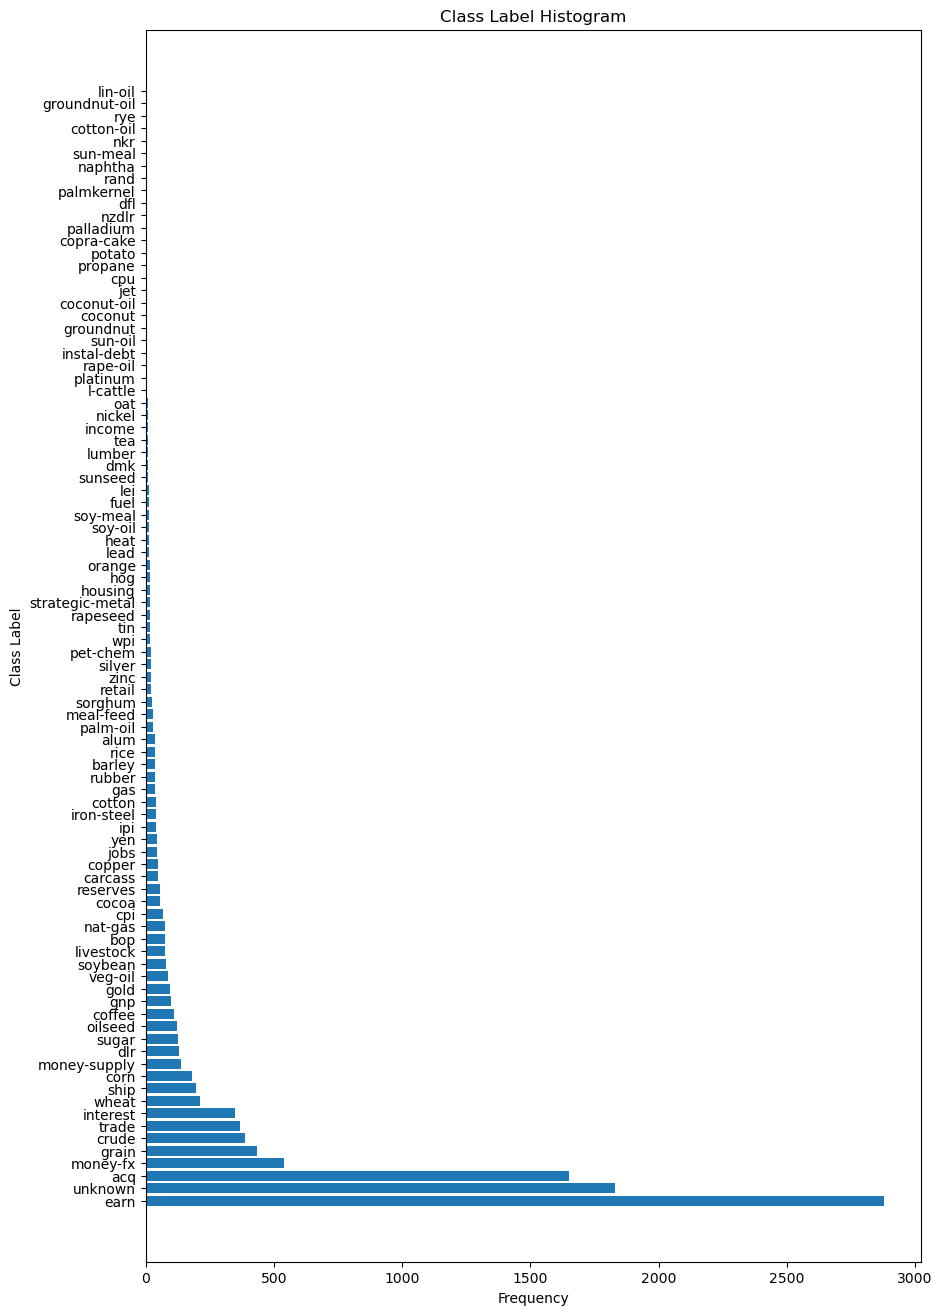

In [46]:
class_count(df['class_label'])

# The most Frequent class is earn class

#  Imbalanced Data 

# Preprocessing Phase

In [47]:
#Remove Special Charcter + punctuation marks Like \ / < > \n ' " . ? ! - ( ) + [ ] _ , ; 
def remove_special_characters(column):
    cleaned_texts = []
    for text in column:
        pattern =  r'[-\/\n\'".,?!(){}\[\]_+;<>,^#!?&\']'

        cleaned_text = re.sub(pattern, '', text)

        cleaned_texts.append(cleaned_text)

    return cleaned_texts
cleaned_column = remove_special_characters(df['document_content'])

In [48]:
df['document_content'] = cleaned_column

In [49]:
del cleaned_column

In [50]:
df

document_content class_label
0      COMPUTER TERMINAL SYSTEMS CPML COMPLETES SALE ...         acq
1      OHIO MATTRESS OMT MAY HAVE LOWER 1ST QTR NET  ...         acq
2      MCLEANS MII US LINES SETS ASSET TRANSFER    CR...         acq
3      CHEMLAWN CHEM RISES ON HOPES FOR HIGHER BIDSAU...         acq
4      COFAB INC BUYS GULFEX FOR UNDISCLOSED AMOUNT  ...         acq
...                                                  ...         ...
11408  PEGASUS GOLD PGULF STARTS MILLING IN MONTANA  ...        zinc
11409  WORLD ZINC STOCKS FALL 7700 TONNES IN FEBRUARY...        zinc
11410  LME DETAILS MARCH 1987 TURNOVER    LONDON Apri...        zinc
11411  BALL BLL TO SUPPLY PENNY BLANKS TO MINTS    MU...        zinc
11412  WESTMIN TO RAISE MYRA FALLS CAPACITY BY 33 PCT...        zinc

[11413 rows x 2 columns]

# Toknization

In [51]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\IMOE001\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# NLTK's Tokenizer

In [52]:
def tokenize(column):
    toknized_column = []
    for text in column : 
        tokens = nltk.word_tokenize(text) #based on whitespace and punctuation
        toknized_column.append(tokens)
    return toknized_column

In [53]:
toknized_column = tokenize(df["document_content"])

In [54]:
df["document_content"] = toknized_column 

In [55]:
del toknized_column

# Case Floding

In [56]:
def lowercase_folding(column):
    lowecase_column = [ ]
    for tokens in column : 
        lowercase_tokens = []
        for token in tokens : 
            lowercase_tokens.append(token.lower())
        lowecase_column.append(lowercase_tokens)   
    return lowecase_column

In [57]:
lowercase_tokens = lowercase_folding(df["document_content"])

In [49]:
lowercase_tokens

[['computer',
  'terminal',
  'systems',
  'cpml',
  'completes',
  'sale',
  'commack',
  'ny',
  'feb',
  '26',
  'computer',
  'terminal',
  'systems',
  'inc',
  'saidit',
  'has',
  'completed',
  'the',
  'sale',
  'of',
  '200000',
  'shares',
  'of',
  'its',
  'commonstock',
  'and',
  'warrants',
  'to',
  'acquire',
  'an',
  'additional',
  'one',
  'mln',
  'shares',
  'tosedio',
  'nv',
  'of',
  'lugano',
  'switzerland',
  'for',
  '50000',
  'dlrs',
  'the',
  'company',
  'said',
  'the',
  'warrants',
  'are',
  'exercisable',
  'for',
  'fiveyears',
  'at',
  'a',
  'purchase',
  'price',
  'of',
  '125',
  'dlrs',
  'per',
  'share',
  'computer',
  'terminal',
  'said',
  'sedio',
  'also',
  'has',
  'the',
  'right',
  'to',
  'buyadditional',
  'shares',
  'and',
  'increase',
  'its',
  'total',
  'holdings',
  'up',
  'to',
  '40',
  'pctof',
  'the',
  'computer',
  'terminals',
  'outstanding',
  'common',
  'stock',
  'undercertain',
  'circumstances',
  '

In [58]:
df["document_content"] = lowercase_tokens 

In [59]:
del lowercase_tokens

In [60]:
# Removeing Stop Words 

In [61]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\IMOE001\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [62]:
stop_words = set(stopwords.words('english'))


In [63]:
def remove_stop_words(column):
    filtered_column = []
    stop_words = set(stopwords.words('english'))
    for tokens in column:
        filtered_tokens = [token for token in tokens if token not in stop_words]
        filtered_column.append(filtered_tokens)
    return filtered_column


In [64]:
df["document_content"] = remove_stop_words(df["document_content"])

# Stemming

In [65]:
porter = PorterStemmer()

In [66]:
def stem_tokens(tokens):
    stemmed_tokens = [porter.stem(token) for token in tokens]
    return stemmed_tokens

In [67]:
def stem_column(column):
    stemmed_column = [stem_tokens(tokens) for tokens in column]
    return stemmed_column

In [68]:
stemmed_column = stem_column(df["document_content"])

In [61]:
stemmed_column

[['comput',
  'termin',
  'system',
  'cpml',
  'complet',
  'sale',
  'commack',
  'ny',
  'feb',
  '26',
  'comput',
  'termin',
  'system',
  'inc',
  'saidit',
  'complet',
  'sale',
  '200000',
  'share',
  'commonstock',
  'warrant',
  'acquir',
  'addit',
  'one',
  'mln',
  'share',
  'tosedio',
  'nv',
  'lugano',
  'switzerland',
  '50000',
  'dlr',
  'compani',
  'said',
  'warrant',
  'exercis',
  'fiveyear',
  'purchas',
  'price',
  '125',
  'dlr',
  'per',
  'share',
  'comput',
  'termin',
  'said',
  'sedio',
  'also',
  'right',
  'buyaddit',
  'share',
  'increas',
  'total',
  'hold',
  '40',
  'pctof',
  'comput',
  'termin',
  'outstand',
  'common',
  'stock',
  'undercertain',
  'circumst',
  'involv',
  'chang',
  'control',
  'thecompani',
  'compani',
  'said',
  'condit',
  'occur',
  'warrant',
  'wouldb',
  'exercis',
  'price',
  'equal',
  '75',
  'pct',
  'common',
  'stocksmarket',
  'price',
  'time',
  'exceed',
  '150',
  'dlr',
  'per',
  'share',


In [69]:
df["document_content"] = stemmed_column

In [70]:
del stemmed_column

In [71]:
def Vocabulary_set_extraction(document_content):
    flattened_content = [word for sublist in document_content for word in sublist]
    
    word_counts = {}
    for word in flattened_content:
        if word in word_counts:
            word_counts[word] += 1
        else:
            word_counts[word] = 1
    
    sorted_word_counts = dict(sorted(word_counts.items(), key=lambda item: item[1] ,  reverse=True))
    
    vocabulary = {word: count for word, count in sorted_word_counts.items() if count > 5}

    return vocabulary

In [72]:
def compute_word_counts_by_class(documents, class_labels, vocabulary):
    word_counts_by_class = defaultdict(lambda: defaultdict(int))
    for word in vocabulary:
        for document, class_label in zip(documents, class_labels):
            if word in document:
                word_counts_by_class[class_label][word] += 1
    return word_counts_by_class

In [199]:
unique_words = Vocabulary_set_extraction(df["document_content"])

In [200]:
#the size of Vocabulary = 86111 =>try to reduce it . 

# Reducing the size of  Vocabulary from 86,111 to 12241 by take only the words with counts greater than 10

In [201]:
len(unique_words)

12241

In [202]:
word_counts_by_class = compute_word_counts_by_class(df['document_content'],df['class_label'],unique_words)

In [203]:
the_vocabulary = pd.DataFrame(word_counts_by_class)

In [204]:
the_vocabulary.head(40)

acq  alum  barley   bop  carcass  cocoa  coconut  coconut-oil  \
said     1453.0  30.0    28.0  55.0     46.0   48.0      2.0          4.0   
mln       703.0  10.0    14.0  41.0     12.0   10.0      2.0          2.0   
dlr       852.0   4.0     4.0  45.0      9.0   10.0      2.0          2.0   
pct       642.0   8.0     5.0  28.0     15.0   12.0      NaN          1.0   
march    1291.0  30.0    27.0  58.0     42.0   44.0      3.0          3.0   
year      227.0  14.0     6.0  45.0     21.0   10.0      1.0          2.0   
bank      206.0   1.0     NaN  22.0      NaN    3.0      NaN          NaN   
us        195.0   4.0    11.0  20.0     19.0    7.0      1.0          2.0   
ct         32.0   1.0     NaN   NaN      NaN    NaN      NaN          NaN   
billion   121.0   1.0     1.0  66.0      2.0    2.0      NaN          NaN   
would     342.0  12.0     3.0  20.0     17.0   22.0      1.0          2.0   
net        60.0   NaN     NaN  10.0      NaN    1.0      NaN          NaN   
price     240.0  12.0     5.0  14.0      8.0   25.0      NaN          2.0   
compani   818.0  12.0     1.0   2.0      6.0    1.0      NaN          NaN   
market    180.0   5.0     7.0  13.0     15.0   16.0      1.0          2.0   
new       462.0  11.0     2.0  11.0      8.0   23.0      2.0          1.0   
loss       49.0   3.0     NaN   4.0      1.0    3.0      NaN          NaN   
share     712.0   NaN     NaN   1.0      2.0    3.0      NaN          1.0   
trade     106.0   5.0     6.0  52.0     14.0   17.0      1.0          2.0   
tonn        3.0  17.0    29.0   NaN     16.0   21.0      2.0          2.0   
rate       24.0   5.0     2.0  16.0      2.0    2.0      NaN          1.0   
april     297.0   6.0     8.0   3.0     15.0   10.0      1.0          1.0   
1986      176.0   5.0     5.0  45.0      9.0    8.0      NaN          NaN   
inc       805.0   1.0     1.0   2.0      8.0    1.0      NaN          NaN   
last      200.0   7.0     3.0  31.0     13.0   18.0      1.0          2.0   
oil        72.0   1.0     1.0  13.0      3.0    2.0      1.0          4.0   
shr         3.0   NaN     NaN   NaN      NaN    NaN      NaN          NaN   
export      6.0   3.0    21.0  35.0     12.0   14.0      3.0          1.0   
corp      694.0   5.0     1.0   2.0      7.0    NaN      NaN          NaN   
also      341.0   5.0     3.0   6.0     15.0   14.0      2.0          1.0   
sale      330.0   4.0     4.0   6.0      1.0    2.0      1.0          1.0   
one       244.0   6.0     4.0  12.0      3.0   14.0      NaN          2.0   
offer     380.0   2.0     2.0   2.0      9.0   12.0      NaN          NaN   
profit     69.0   3.0     NaN   2.0      2.0    1.0      NaN          NaN   
stock     425.0   3.0     4.0   5.0      4.0   33.0      NaN          1.0   
product   129.0  10.0     2.0  10.0     18.0    4.0      2.0          1.0   
expect    217.0   6.0     3.0  23.0      8.0   13.0      NaN          1.0   
oper      204.0   8.0     3.0   1.0     10.0   11.0      NaN          1.0   
report    115.0   4.0     4.0  11.0      8.0    6.0      1.0          1.0   
two       201.0   9.0     3.0  10.0      5.0   11.0      NaN          NaN   

         coffee  copper  ...  unknown  veg-oil  wheat   wpi   yen  zinc  \
said      100.0    43.0  ...   1579.0     76.0  171.0  16.0  34.0  16.0   
mln        36.0    12.0  ...   1061.0     26.0   81.0   1.0   4.0   7.0   
dlr        34.0    11.0  ...   1136.0     26.0   56.0   2.0  19.0   5.0   
pct        30.0    15.0  ...    856.0     14.0   48.0  18.0  15.0   7.0   
march      87.0    28.0  ...   1422.0     72.0  167.0  17.0  32.0  19.0   
year       47.0    13.0  ...    492.0     24.0   69.0  12.0  15.0   4.0   
bank       13.0     NaN  ...    682.0      4.0    1.0   2.0  22.0   NaN   
us         23.0    11.0  ...    264.0     36.0  119.0   5.0  25.0   6.0   
ct          NaN    10.0  ...     18.0      NaN    NaN   NaN   NaN   1.0   
billion    16.0     3.0  ...    497.0      4.0   12.0   1.0   6.0   NaN   
would      47.0    12.0  ... 

In [205]:
del word_counts_by_class

In [206]:
#Handle the missing + unKnown word + compute the conidtional probability for each word  

In [207]:
the_vocabulary.isna().sum().sum()

986670

In [208]:
num_rows, num_columns = the_vocabulary.shape

In [209]:
total_count_for_vocabulary = num_rows * num_columns

In [210]:
Sparsity = ((the_vocabulary.isna().sum().sum()) / total_count_for_vocabulary)*100

In [211]:
Sparsity

88.57550422782022

In [212]:
# handle the missing 

In [213]:
the_vocabulary = the_vocabulary.fillna(0)

In [214]:
the_vocabulary

acq  alum  barley   bop  carcass  cocoa  coconut  \
said             1453.0  30.0    28.0  55.0     46.0   48.0      2.0   
mln               703.0  10.0    14.0  41.0     12.0   10.0      2.0   
dlr               852.0   4.0     4.0  45.0      9.0   10.0      2.0   
pct               642.0   8.0     5.0  28.0     15.0   12.0      0.0   
march            1291.0  30.0    27.0  58.0     42.0   44.0      3.0   
...                 ...   ...     ...   ...      ...    ...      ...   
sayad               0.0   0.0     0.0   0.0      0.0    0.0      0.0   
dlreurocommerci     0.0   0.0     0.0   0.0      0.0    0.0      0.0   
fernandez           0.0   0.0     0.0   0.0      0.0    0.0      0.0   
indentur            0.0   0.0     0.0   0.0      0.0    0.0      0.0   
nephew              0.0   0.0     0.0   0.0      0.0    0.0      0.0   

                 coconut-oil  coffee  copper  ...  unknown  veg-oil  wheat  \
said                     4.0   100.0    43.0  ...   1579.0     76.0  171.0   
mln                      2.0    36.0    12.0  ...   1061.0     26.0   81.0   
dlr                      2.0    34.0    11.0  ...   1136.0     26.0   56.0   
pct                      1.0    30.0    15.0  ...    856.0     14.0   48.0   
march                    3.0    87.0    28.0  ...   1422.0     72.0  167.0   
...                      ...     ...     ...  ...      ...      ...    ...   
sayad                    0.0     0.0     0.0  ...      3.0      0.0    0.0   
dlreurocommerci          0.0     0.0     0.0  ...      6.0      0.0    0.0   
fernandez                0.0     0.0     0.0  ...      4.0      0.0    0.0   
indentur                 0.0     0.0     0.0  ...      5.0      0.0    0.0   
nephew                   0.0     0.0     0.0  ...      2.0      0.0    0.0   

                  wpi   yen  zinc  sun-meal  castor-oil  lin-oil  rye  
said             16.0  34.0  16.0       0.0         0.0      0.0  0.0  
mln               1.0   4.0   7.0       0.0         0.0      0.0  0.0  
dlr               2.0  19.0   5.0       1.0         0.0      0.0  0.0  
pct              18.0  15.0   7.0       0.0         0.0      0.0  0.0  
march            17.0  32.0  19.0       0.0         1.0      1.0  0.0  
...               ...   ...   ...       ...         ...      ...  ...  
sayad             0.0   0.0   0.0       0.0         0.0      0.0  0.0  
dlreurocommerci   0.0   0.0   0.0       0.0         0.0      0.0  0.0  
fernandez         0.0   0.0   0.0       0.0         0.0      0.0  0.0  
indentur          0.0   0.0   0.0       0.0         0.0      0.0  0.0  
nephew            0.0   0.0   0.0       0.0         0.0      0.0  0.0  

[12241 rows x 91 columns]

In [215]:
transposed_the_vocabulary = the_vocabulary.transpose()

In [216]:
def most_frequent_words(df):
    most_frequent_words = {}
    for class_name, row in df.iterrows():
        most_frequent_word = row.idxmax()
        most_frequent_words[class_name] = most_frequent_word
    
    for class_name, word in most_frequent_words.items():
        print(f"Most frequent word in class '{class_name}': {word}")

In [217]:
most_frequent_words(transposed_the_vocabulary)

Most frequent word in class 'acq': said
Most frequent word in class 'alum': said
Most frequent word in class 'barley': barley
Most frequent word in class 'bop': billion
Most frequent word in class 'carcass': said
Most frequent word in class 'cocoa': cocoa
Most frequent word in class 'coconut': philippin
Most frequent word in class 'coconut-oil': said
Most frequent word in class 'coffee': coffe
Most frequent word in class 'copper': copper
Most frequent word in class 'copra-cake': said
Most frequent word in class 'corn': said
Most frequent word in class 'cotton': cotton
Most frequent word in class 'cotton-oil': said
Most frequent word in class 'cpi': pct
Most frequent word in class 'cpu': pct
Most frequent word in class 'crude': oil
Most frequent word in class 'dfl': said
Most frequent word in class 'dlr': dollar
Most frequent word in class 'dmk': bank
Most frequent word in class 'earn': march
Most frequent word in class 'fuel': said
Most frequent word in class 'gas': said
Most frequent 

In [69]:
df.to_csv('C:\\Users\\IMOE001\\Text Classification\\preprocessed_df.csv', index=False)

# Handle out-of-vocabulary words 

In [218]:
the_vocabulary.loc['<UNK>'] = 1

In [219]:
the_vocabulary

acq  alum  barley   bop  carcass  cocoa  coconut  \
said             1453.0  30.0    28.0  55.0     46.0   48.0      2.0   
mln               703.0  10.0    14.0  41.0     12.0   10.0      2.0   
dlr               852.0   4.0     4.0  45.0      9.0   10.0      2.0   
pct               642.0   8.0     5.0  28.0     15.0   12.0      0.0   
march            1291.0  30.0    27.0  58.0     42.0   44.0      3.0   
...                 ...   ...     ...   ...      ...    ...      ...   
dlreurocommerci     0.0   0.0     0.0   0.0      0.0    0.0      0.0   
fernandez           0.0   0.0     0.0   0.0      0.0    0.0      0.0   
indentur            0.0   0.0     0.0   0.0      0.0    0.0      0.0   
nephew              0.0   0.0     0.0   0.0      0.0    0.0      0.0   
<UNK>               1.0   1.0     1.0   1.0      1.0    1.0      1.0   

                 coconut-oil  coffee  copper  ...  unknown  veg-oil  wheat  \
said                     4.0   100.0    43.0  ...   1579.0     76.0  171.0   
mln                      2.0    36.0    12.0  ...   1061.0     26.0   81.0   
dlr                      2.0    34.0    11.0  ...   1136.0     26.0   56.0   
pct                      1.0    30.0    15.0  ...    856.0     14.0   48.0   
march                    3.0    87.0    28.0  ...   1422.0     72.0  167.0   
...                      ...     ...     ...  ...      ...      ...    ...   
dlreurocommerci          0.0     0.0     0.0  ...      6.0      0.0    0.0   
fernandez                0.0     0.0     0.0  ...      4.0      0.0    0.0   
indentur                 0.0     0.0     0.0  ...      5.0      0.0    0.0   
nephew                   0.0     0.0     0.0  ...      2.0      0.0    0.0   
<UNK>                    1.0     1.0     1.0  ...      1.0      1.0    1.0   

                  wpi   yen  zinc  sun-meal  castor-oil  lin-oil  rye  
said             16.0  34.0  16.0       0.0         0.0      0.0  0.0  
mln               1.0   4.0   7.0       0.0         0.0      0.0  0.0  
dlr               2.0  19.0   5.0       1.0         0.0      0.0  0.0  
pct              18.0  15.0   7.0       0.0         0.0      0.0  0.0  
march            17.0  32.0  19.0       0.0         1.0      1.0  0.0  
...               ...   ...   ...       ...         ...      ...  ...  
dlreurocommerci   0.0   0.0   0.0       0.0         0.0      0.0  0.0  
fernandez         0.0   0.0   0.0       0.0         0.0      0.0  0.0  
indentur          0.0   0.0   0.0       0.0         0.0      0.0  0.0  
nephew            0.0   0.0   0.0       0.0         0.0      0.0  0.0  
<UNK>             1.0   1.0   1.0       1.0         1.0      1.0  1.0  

[12242 rows x 91 columns]

# Learning Modle Parmetars 

In [220]:
#compute the conditional probability for each words

In [221]:
def compute_conditional_probabilities(df):
    class_counts = df.sum(axis=0)
    
    # Add 1 to both numerator and denominator for Laplace smoothing
    conditional_probabilities = (df + 1) / (class_counts + len(df.index))
    
    return conditional_probabilities


In [222]:
conditional_probabilities_df = compute_conditional_probabilities(the_vocabulary)

In [223]:
conditional_probabilities_df

acq      alum    barley       bop   carcass     cocoa  \
said             0.015801  0.002172  0.002053  0.003006  0.002954  0.002866   
mln              0.007651  0.000771  0.001062  0.002254  0.000817  0.000643   
dlr              0.009270  0.000350  0.000354  0.002469  0.000629  0.000643   
pct              0.006988  0.000631  0.000425  0.001557  0.001006  0.000760   
march            0.014040  0.002172  0.001982  0.003167  0.002703  0.002632   
...                   ...       ...       ...       ...       ...       ...   
dlreurocommerci  0.000011  0.000070  0.000071  0.000054  0.000063  0.000058   
fernandez        0.000011  0.000070  0.000071  0.000054  0.000063  0.000058   
indentur         0.000011  0.000070  0.000071  0.000054  0.000063  0.000058   
nephew           0.000011  0.000070  0.000071  0.000054  0.000063  0.000058   
<UNK>            0.000022  0.000140  0.000142  0.000107  0.000126  0.000117   

                  coconut  coconut-oil    coffee    copper  ...   unknown  \
said             0.000242     0.000394  0.004557  0.002960  ...  0.013559   
mln              0.000242     0.000236  0.001669  0.000874  ...  0.009114   
dlr              0.000242     0.000236  0.001579  0.000807  ...  0.009758   
pct              0.000081     0.000158  0.001399  0.001076  ...  0.007355   
march            0.000323     0.000315  0.003971  0.001951  ...  0.012212   
...                   ...          ...       ...       ...  ...       ...   
dlreurocommerci  0.000081     0.000079  0.000045  0.000067  ...  0.000060   
fernandez        0.000081     0.000079  0.000045  0.000067  ...  0.000043   
indentur         0.000081     0.000079  0.000045  0.000067  ...  0.000051   
nephew           0.000081     0.000079  0.000045  0.000067  ...  0.000026   
<UNK>            0.000161     0.000158  0.000090  0.000135  ...  0.000017   

                  veg-oil     wheat       wpi       yen      zinc  sun-meal  \
said             0.004255  0.006429  0.001276  0.002138  0.001266  0.000081   
mln              0.001492  0.003065  0.000150  0.000305  0.000596  0.000081   
dlr              0.001492  0.002130  0.000225  0.001222  0.000447  0.000162   
pct              0.000829  0.001831  0.001426  0.000977  0.000596  0.000081   
march            0.004034  0.006279  0.001351  0.002016  0.001489  0.000081   
...                   ...       ...       ...       ...       ...       ...   
dlreurocommerci  0.000055  0.000037  0.000075  0.000061  0.000074  0.000081   
fernandez        0.000055  0.000037  0.000075  0.000061  0.000074  0.000081   
indentur         0.000055  0.000037  0.000075  0.000061  0.000074  0.000081   
nephew           0.000055  0.000037  0.000075  0.000061  0.000074  0.000081   
<UNK>            0.000111  0.000075  0.000150  0.000122  0.000149  0.000162   

                 castor-oil   lin-oil       rye  
said               0.000081  0.000081  0.000081  
mln                0.000081  0.000081  0.000081  
dlr                0.000081  0.000081  0.000081  
pct                0.000081  0.000081  0.000081  
march              0.000163  0.000162  0.000081  
...                     ...       ...       ...  
dlreurocommerci    0.000081  0.000081  0.000081  
fernandez          0.000081  0.000081  0.000081  
indentur           0.000081  0.000081  0.000081  
nephew             0.000081  0.000081  0.000081  
<UNK>              0.000163  0.000162  0.000161  

[12242 rows x 91 columns]

In [224]:
def compute_prior_probabilities(df):
    total_documents = df.sum().sum() #all documents in the corpus 
    class_counts = df.sum()
    prior_probabilities = class_counts / total_documents
    return prior_probabilities

In [225]:
prior_probabilities_for_each_class = compute_prior_probabilities(the_vocabulary)

In [226]:
prior_probabilities_for_each_class

acq           0.120353
alum          0.003065
barley        0.002842
bop           0.009638
carcass       0.005532
                ...   
zinc          0.001795
sun-meal      0.000103
castor-oil    0.000053
lin-oil       0.000154
rye           0.000244
Length: 91, dtype: float64

# Training-Phase

In [227]:
def predict_class(document, conditional_probabilities_df, prior_probabilities_series):
    class_probabilities = {}
    for class_name in conditional_probabilities_df.columns:
        probability = prior_probabilities_series[class_name]
        for word in document:
            if word in conditional_probabilities_df.index:
                probability *= (conditional_probabilities_df.loc[word, class_name] ** document[word])
            else:
                # Assign the conditional probability of <UNK> if the word is not in the vocabulary
                probability *= (conditional_probabilities_df.loc['<UNK>', class_name] ** document[word])
        class_probabilities[class_name] = probability
    predicted_class = max(class_probabilities, key=class_probabilities.get)
    return predicted_class

# Evaluation-Phase

In [228]:
def evaluate_model_f1_per_class(data, conditional_probabilities_df, prior_probabilities_for_each_class):
    labels = data['class_label']
    features = data['document_content']
    
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    
    train_predictions = [predict_class(Counter(document), conditional_probabilities_df , prior_probabilities_for_each_class) for document in X_train]
    train_f1_per_class = f1_score(y_train, train_predictions, average=None)  # Compute F1 score for each class
    
    test_predictions = [predict_class(Counter(document), conditional_probabilities_df, prior_probabilities_for_each_class) for document in X_test]
    test_f1_per_class = f1_score(y_test, test_predictions, average=None)  # Compute F1 score for each class
    
    # Create dictionaries pairing classes with their corresponding F1 scores
    train_f1_dict = {class_label: f1_score for class_label, f1_score in zip(set(y_train), train_f1_per_class)}
    test_f1_dict = {class_label: f1_score for class_label, f1_score in zip(set(y_test), test_f1_per_class)}
    
    f1_scores = {
        'train_f1_per_class': train_f1_dict,
        'test_f1_per_class': test_f1_dict
    }
    
    return f1_scores


In [229]:
evaluation_result = evaluate_model_f1_per_class(df ,conditional_probabilities_df ,prior_probabilities_for_each_class)

In [103]:
#The macro-averaged F1 score 

In [104]:
evaluation_result

{'train_f1_per_class': {'reserves': 0.48166948674562887,
  'housing': 0.5,
  'cotton-oil': 0.0,
  'l-cattle': 0.3373493975903614,
  'meal-feed': 0.13043478260869565,
  'lead': 0.0,
  'rice': 0.43750000000000006,
  'coconut-oil': 0.0,
  'platinum': 0.0,
  'jet': 0.5735294117647058,
  'tin': 0.5901639344262295,
  'groundnut-oil': 0.0,
  'gas': 0.17708333333333331,
  'nat-gas': 0.1142857142857143,
  'soy-oil': 0.0,
  'potato': 0.6526315789473683,
  'alum': 0.0,
  'grain': 0.44017094017094016,
  'livestock': 0.0,
  'money-fx': 0.22666666666666666,
  'gnp': 0.0,
  'lei': 0.905367231638418,
  'pet-chem': 0.0,
  'dfl': 0.0,
  'rand': 0.35398230088495575,
  'zinc': 0.5277777777777777,
  'acq': 0.3913595933926302,
  'ipi': 0.0,
  'cpu': 0.0,
  'dlr': 0.0,
  'sorghum': 0.0,
  'sunseed': 0.42857142857142855,
  'instal-debt': 0.0,
  'nkr': 0.0,
  'heat': 0.6014760147601477,
  'groundnut': 0.40909090909090906,
  'copra-cake': 0.2702702702702703,
  'veg-oil': 0.0,
  'hog': 0.5714285714285715,
  'tra

In [230]:
plt.rcParams.update(plt.rcParamsDefault)

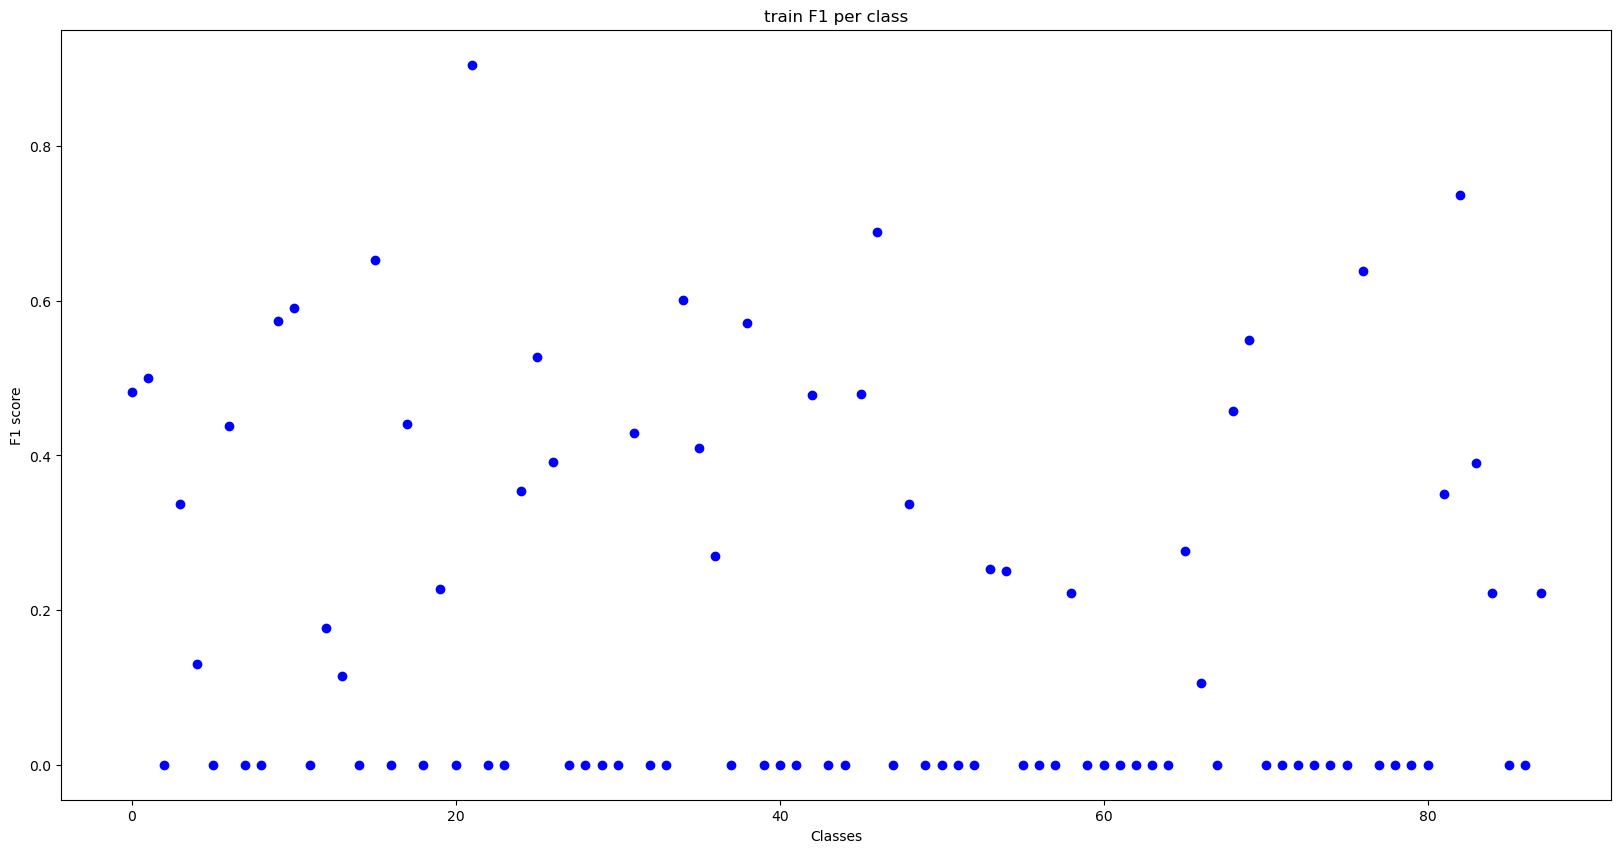

In [231]:
train_f1_per_class = evaluation_result['train_f1_per_class']

classes = list(train_f1_per_class.keys())
f1_scores = list(train_f1_per_class.values())

plt.figure(figsize=(20, 10))  

plt.plot( f1_scores , 'ob'  )
plt.ylabel("F1 score")
plt.xlabel("Classes")
plt.title("train F1 per class")
plt.xkcd()
plt.show()

In [232]:
plt.rcParams.update(plt.rcParamsDefault)

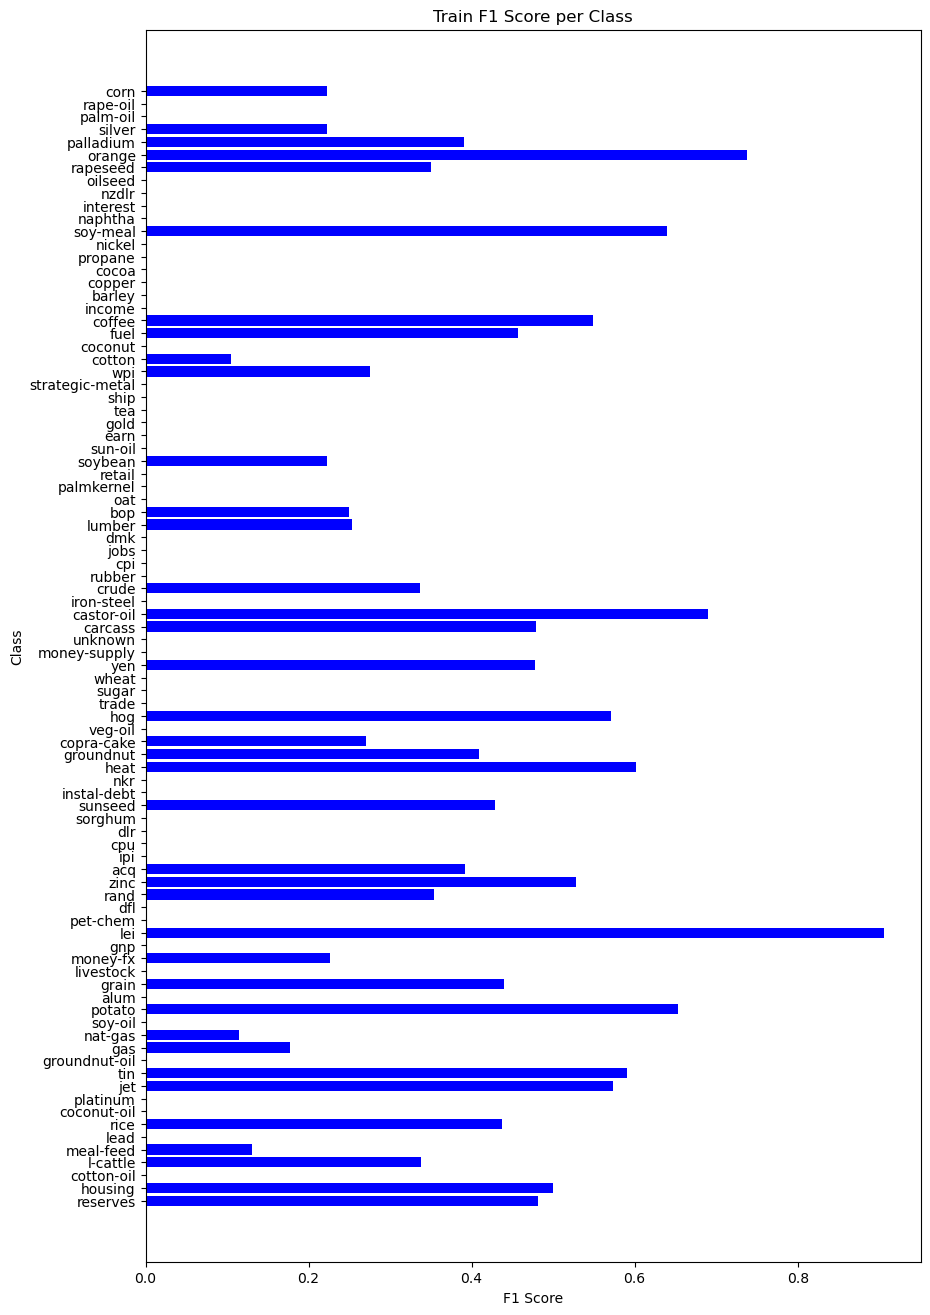

In [233]:
classes = list(train_f1_per_class.keys())
f1_scores = list(train_f1_per_class.values())

fig, ax = plt.subplots(figsize=(10, 16))
ax.barh(classes, f1_scores, color='blue')
ax.set_title('Train F1 Score per Class')
ax.set_xlabel('F1 Score')
ax.set_ylabel('Class')
plt.show()


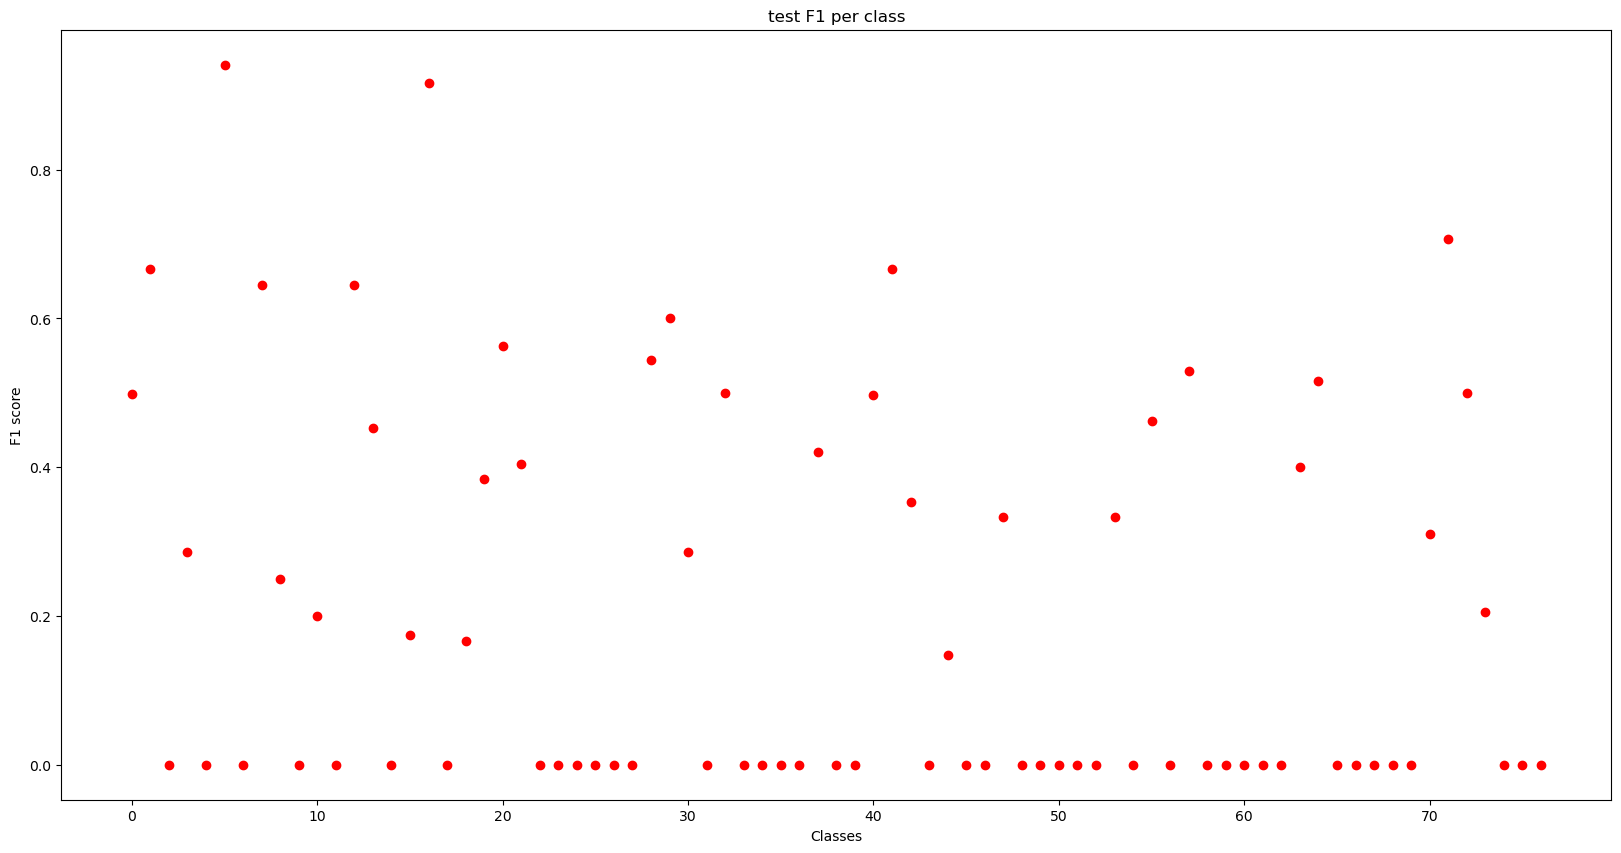

In [234]:
test_f1_per_class = evaluation_result['test_f1_per_class']

classes = list(test_f1_per_class.keys())
f1_scores = list(test_f1_per_class.values())

plt.figure(figsize=(20, 10))  

plt.plot( f1_scores , 'or'  )
plt.ylabel("F1 score")
plt.xlabel("Classes")
plt.title("test F1 per class")
plt.xkcd()
plt.show()

In [235]:
plt.rcParams.update(plt.rcParamsDefault)

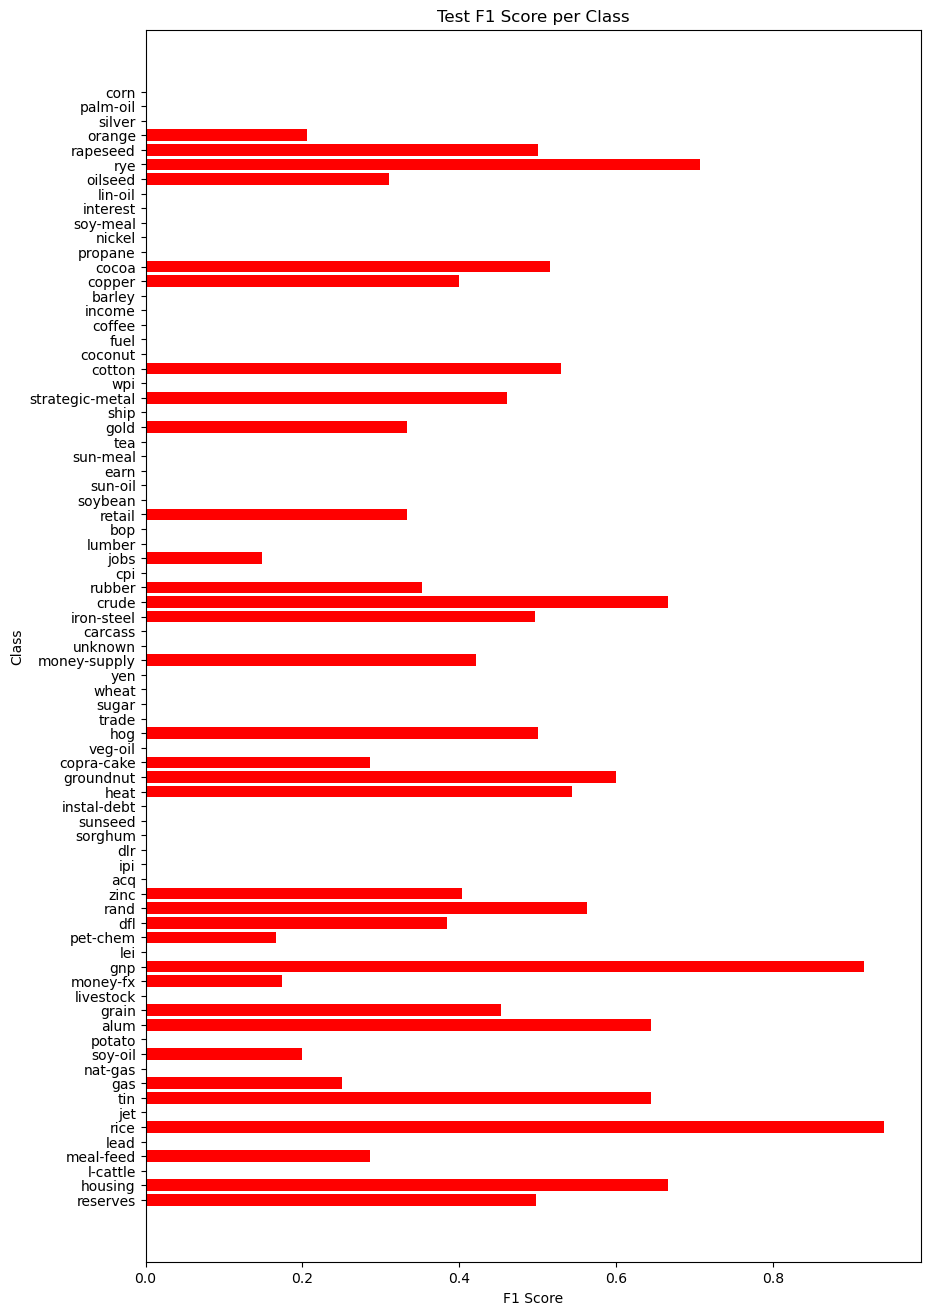

In [236]:
# Extract data from train_f1_per_class
classes = list(test_f1_per_class.keys())
f1_scores = list(test_f1_per_class.values())

# Plot the results in a horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 16))
ax.barh(classes, f1_scores, color='red' )
ax.set_title('Test F1 Score per Class')
ax.set_xlabel('F1 Score')
ax.set_ylabel('Class')
plt.show()

# macro-average F1 score

Macro-average F1 score for train set: 0.17931513713499328
Macro-average F1 score for test set: 0.20138000449419513


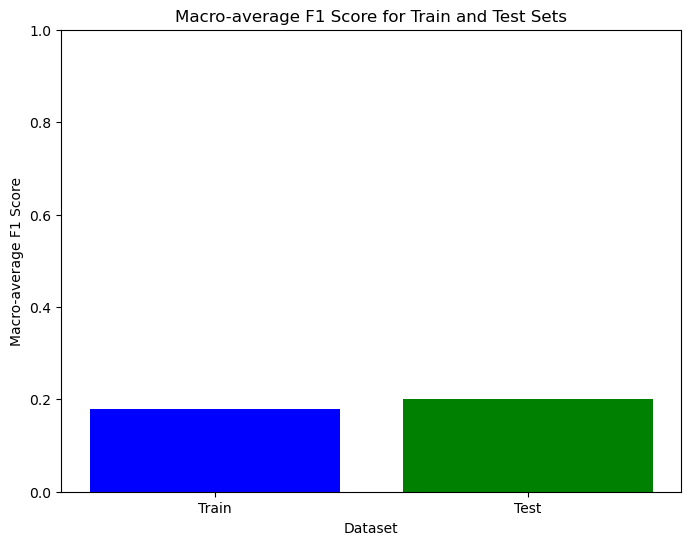

In [237]:
train_f1_per_class = np.array(list(evaluation_result['train_f1_per_class'].values()))
test_f1_per_class = np.array(list(evaluation_result['test_f1_per_class'].values()))

macro_train_f1 = np.mean(train_f1_per_class)
macro_test_f1 = np.mean(test_f1_per_class)

print("Macro-average F1 score for train set:", macro_train_f1)
print("Macro-average F1 score for test set:", macro_test_f1)

plt.figure(figsize=(8, 6))
plt.bar(['Train', 'Test'], [macro_train_f1, macro_test_f1], color=['blue', 'green'])
plt.xlabel('Dataset')
plt.ylabel('Macro-average F1 Score')
plt.title('Macro-average F1 Score for Train and Test Sets')
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.show()

   # Compute the top 10 most frequent words in each class

In [238]:
#try to use another approch , and classifers 

In [73]:
df

document_content class_label
0      [comput, termin, system, cpml, complet, sale, ...         acq
1      [ohio, mattress, omt, may, lower, 1st, qtr, ne...         acq
2      [mclean, mii, us, line, set, asset, transfer, ...         acq
3      [chemlawn, chem, rise, hope, higher, bidsautho...         acq
4      [cofab, inc, buy, gulfex, undisclos, amount, h...         acq
...                                                  ...         ...
11408  [pegasu, gold, pgulf, start, mill, montana, je...        zinc
11409  [world, zinc, stock, fall, 7700, tonn, februar...        zinc
11410  [lme, detail, march, 1987, turnov, london, apr...        zinc
11411  [ball, bll, suppli, penni, blank, mint, munci,...        zinc
11412  [westmin, rais, myra, fall, capac, 33, pct, ca...        zinc

[11413 rows x 2 columns]

In [74]:
def create_feature_matrix(df, top_words):
    vectorizer = CountVectorizer(vocabulary=top_words)
    X = vectorizer.fit_transform(df['document_content_str'])
    return X

In [75]:
def top_10_frequent_words(df, n=10):
    most_frequent_words = {}
    for class_name, group_df in df.groupby('class_label'):
        word_counter = Counter()
        for row in group_df['document_content']:
            word_counter.update(row)
        top_words = [word for word, _ in word_counter.most_common(n)]
        most_frequent_words[class_name] = top_words

    return most_frequent_words

In [76]:
most_frequent_words = top_10_frequent_words(df)

In [86]:
most_frequent_words

{'acq': ['said',
  'dlr',
  'share',
  'compani',
  'march',
  'mln',
  'pct',
  'inc',
  'offer',
  'corp'],
 'alum': ['said',
  'aluminium',
  'march',
  'tonn',
  'smelter',
  'price',
  'alcan',
  'new',
  'mln',
  'aluminum'],
 'barley': ['tonn',
  'barley',
  'wheat',
  'said',
  'export',
  'mln',
  'march',
  'acr',
  'french',
  'maiz'],
 'bop': ['billion',
  'said',
  'dlr',
  'mln',
  'deficit',
  'pct',
  'trade',
  'year',
  'surplu',
  'account'],
 'carcass': ['said',
  'beef',
  'meat',
  'us',
  'march',
  'market',
  'tonn',
  'product',
  'would',
  'year'],
 'castor-oil': ['tonn',
  'india',
  'castor',
  'oil',
  'export',
  'march',
  'estim',
  '198586',
  'crop',
  '198687'],
 'cocoa': ['cocoa',
  'said',
  'stock',
  'buffer',
  'deleg',
  'price',
  'icco',
  'consum',
  'produc',
  'rule'],
 'coconut': ['coconut',
  'philippin',
  'export',
  'tonn',
  'product',
  'mln',
  'tax',
  'said',
  'januari',
  'ec'],
 'coconut-oil': ['oil',
  'said',
  'mln',
  'pa

In [77]:
top_words = set(word for words in most_frequent_words.values() for word in words)

In [78]:
top_words

{'1',
 '150',
 '156',
 '173',
 '198586',
 '1986',
 '198687',
 '1987',
 '204',
 '298',
 '312',
 '316',
 '370',
 '490',
 '52',
 ':',
 'account',
 'acr',
 'adjust',
 'africa',
 'african',
 'ago',
 'agreement',
 'agricultur',
 'alcan',
 'aluminium',
 'aluminum',
 'amend',
 'analyst',
 'andmeal',
 'apr',
 'april',
 'area',
 'argentin',
 'bank',
 'barley',
 'barrel',
 'basi',
 'basket',
 'beef',
 'billion',
 'bond',
 'brazil',
 'buffer',
 'butan',
 'cake',
 'caltex',
 'canadian',
 'capac',
 'cargo',
 'castor',
 'cattl',
 'cent',
 'central',
 'chemic',
 'chicago',
 'cocoa',
 'coconut',
 'coffe',
 'compani',
 'consolid',
 'consum',
 'contract',
 'copper',
 'corn',
 'corp',
 'cotton',
 'countertrad',
 'cpb',
 'credit',
 'crop',
 'crown',
 'crude',
 'ct',
 'currenc',
 'cwt',
 'dealer',
 'debt',
 'decemb',
 'deficit',
 'deleg',
 'deliveri',
 'depart',
 'dlr',
 'dollar',
 'drill',
 'dutch',
 'duti',
 'ec',
 'ecuador',
 'egypt',
 'employ',
 'estim',
 'exchang',
 'expel',
 'export',
 'farmer',
 'fat

In [84]:
len(top_words)

283

In [79]:
df

document_content class_label
0      [comput, termin, system, cpml, complet, sale, ...         acq
1      [ohio, mattress, omt, may, lower, 1st, qtr, ne...         acq
2      [mclean, mii, us, line, set, asset, transfer, ...         acq
3      [chemlawn, chem, rise, hope, higher, bidsautho...         acq
4      [cofab, inc, buy, gulfex, undisclos, amount, h...         acq
...                                                  ...         ...
11408  [pegasu, gold, pgulf, start, mill, montana, je...        zinc
11409  [world, zinc, stock, fall, 7700, tonn, februar...        zinc
11410  [lme, detail, march, 1987, turnov, london, apr...        zinc
11411  [ball, bll, suppli, penni, blank, mint, munci,...        zinc
11412  [westmin, rais, myra, fall, capac, 33, pct, ca...        zinc

[11413 rows x 2 columns]

In [28]:
preprocessed_df = pd.read_csv('C:\\Users\\IMOE001\\Text Classification\\preprocessed_df.csv')

In [29]:
preprocessed_df

document_content class_label  \
0      ['comput', 'termin', 'system', 'cpml', 'comple...         acq   
1      ['ohio', 'mattress', 'omt', 'may', 'lower', '1...         acq   
2      ['mclean', 'mii', 'us', 'line', 'set', 'asset'...         acq   
3      ['chemlawn', 'chem', 'rise', 'hope', 'higher',...         acq   
4      ['cofab', 'inc', 'buy', 'gulfex', 'undisclos',...         acq   
...                                                  ...         ...   
11408  ['pegasu', 'gold', 'pgulf', 'start', 'mill', '...        zinc   
11409  ['world', 'zinc', 'stock', 'fall', '7700', 'to...        zinc   
11410  ['lme', 'detail', 'march', '1987', 'turnov', '...        zinc   
11411  ['ball', 'bll', 'suppli', 'penni', 'blank', 'm...        zinc   
11412  ['westmin', 'rais', 'myra', 'fall', 'capac', '...        zinc   

                                    document_content_str  
0      comput termin system cpml complet sale commack...  
1      ohio mattress omt may lower 1st qtr net clevel...  
2      mclean mii us line set asset transfer cranford...  
3      chemlawn chem rise hope higher bidsauthor cal ...  
4      cofab inc buy gulfex undisclos amount houston ...  
...                                                  ...  
11408  pegasu gold pgulf start mill montana jefferson...  
11409  world zinc stock fall 7700 tonn februari eindh...  
11410  lme detail march 1987 turnov london april 2 lo...  
11411  ball bll suppli penni blank mint munci ind apr...  
11412  westmin rais myra fall capac 33 pct calgari al...  

[11413 rows x 3 columns]

In [30]:
df = preprocessed_df

In [31]:
df

document_content class_label  \
0      ['comput', 'termin', 'system', 'cpml', 'comple...         acq   
1      ['ohio', 'mattress', 'omt', 'may', 'lower', '1...         acq   
2      ['mclean', 'mii', 'us', 'line', 'set', 'asset'...         acq   
3      ['chemlawn', 'chem', 'rise', 'hope', 'higher',...         acq   
4      ['cofab', 'inc', 'buy', 'gulfex', 'undisclos',...         acq   
...                                                  ...         ...   
11408  ['pegasu', 'gold', 'pgulf', 'start', 'mill', '...        zinc   
11409  ['world', 'zinc', 'stock', 'fall', '7700', 'to...        zinc   
11410  ['lme', 'detail', 'march', '1987', 'turnov', '...        zinc   
11411  ['ball', 'bll', 'suppli', 'penni', 'blank', 'm...        zinc   
11412  ['westmin', 'rais', 'myra', 'fall', 'capac', '...        zinc   

                                    document_content_str  
0      comput termin system cpml complet sale commack...  
1      ohio mattress omt may lower 1st qtr net clevel...  
2      mclean mii us line set asset transfer cranford...  
3      chemlawn chem rise hope higher bidsauthor cal ...  
4      cofab inc buy gulfex undisclos amount houston ...  
...                                                  ...  
11408  pegasu gold pgulf start mill montana jefferson...  
11409  world zinc stock fall 7700 tonn februari eindh...  
11410  lme detail march 1987 turnov london april 2 lo...  
11411  ball bll suppli penni blank mint munci ind apr...  
11412  westmin rais myra fall capac 33 pct calgari al...  

[11413 rows x 3 columns]

# Represant each document by vectore of 10 frequent words of it's class . 

In [80]:
df['document_content_str'] = df['document_content'].apply(lambda tokens: ' '.join(tokens))

In [91]:
df

document_content class_label  \
0      [comput, termin, system, cpml, complet, sale, ...         acq   
1      [ohio, mattress, omt, may, lower, 1st, qtr, ne...         acq   
2      [mclean, mii, us, line, set, asset, transfer, ...         acq   
3      [chemlawn, chem, rise, hope, higher, bidsautho...         acq   
4      [cofab, inc, buy, gulfex, undisclos, amount, h...         acq   
...                                                  ...         ...   
11408  [pegasu, gold, pgulf, start, mill, montana, je...        zinc   
11409  [world, zinc, stock, fall, 7700, tonn, februar...        zinc   
11410  [lme, detail, march, 1987, turnov, london, apr...        zinc   
11411  [ball, bll, suppli, penni, blank, mint, munci,...        zinc   
11412  [westmin, rais, myra, fall, capac, 33, pct, ca...        zinc   

                                    document_content_str  
0      comput termin system cpml complet sale commack...  
1      ohio mattress omt may lower 1st qtr net clevel...  
2      mclean mii us line set asset transfer cranford...  
3      chemlawn chem rise hope higher bidsauthor cal ...  
4      cofab inc buy gulfex undisclos amount houston ...  
...                                                  ...  
11408  pegasu gold pgulf start mill montana jefferson...  
11409  world zinc stock fall 7700 tonn februari eindh...  
11410  lme detail march 1987 turnov london april 2 lo...  
11411  ball bll suppli penni blank mint munci ind apr...  
11412  westmin rais myra fall capac 33 pct calgari al...  

[11413 rows x 3 columns]

In [92]:
features = create_feature_matrix(df, top_words)

In [93]:
most_top_frequent_words_df = pd.DataFrame(features.toarray())
most_top_frequent_words_df['class_label'] = df['class_label']

In [94]:
most_top_frequent_words_df

0  1  2  3  4  5  6  7  8  9  ...  274  275  276  277  278  279  280  \
0      0  1  0  0  0  0  0  0  0  0  ...    0    0    0    2    0    0    0   
1      0  0  0  0  0  0  0  0  0  0  ...    0    0    0    1    2    0    0   
2      0  0  0  0  0  0  0  0  0  0  ...    0    0    0    1    0    0    0   
3      0  0  0  0  0  1  0  0  0  0  ...    0    0    0    2    1    0    1   
4      0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0   
...   .. .. .. .. .. .. .. .. .. ..  ...  ...  ...  ...  ...  ...  ...  ...   
11408  0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0   
11409  0  0  0  0  0  3  0  0  0  0  ...    0    0    0    0    0    0    0   
11410  0  0  0  0  0  0  0  2  0  0  ...    0    0    0    0    0    0    0   
11411  0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0   
11412  0  0  0  0  0  3  0  0  0  0  ...    0    0    0    0    1    0    0   

       281  282  class_label  
0        0    0          acq  
1        0    0          acq  
2        0    0          acq  
3        0    0          acq  
4        0    0          acq  
...    ...  ...          ...  
11408    0    2         zinc  
11409    0    5         zinc  
11410    0    2         zinc  
11411    0    0         zinc  
11412    0    2         zinc  

[11413 rows x 284 columns]

# Train the classifers on this Vectors 

In [108]:
def split_data(df, target, test_size=0.2, random_state=None):
    X = df.drop(columns=[target])
    y = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    return X_train, X_test, y_train, y_test


In [109]:
def evaluate_classifiers(X_train, X_test, y_train, y_test, classifiers):
    f1_scores = {}
    for clf_name, classifier in classifiers.items():
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        f1 = f1_score(y_test, y_pred, average='macro')
        f1_scores[clf_name] = f1
        print(f"Macro Average F1 score ({clf_name}): {f1}")
    return f1_scores

In [110]:
def plot_f1_scores_for_classifiers(f1_scores):
    plt.figure(figsize=(10, 6))
    plt.bar(f1_scores.keys(), f1_scores.values(), color='skyblue')
    plt.xlabel('Classifier')
    plt.ylabel('Macro Average F1 Score')
    plt.title('Macro Average F1 Score for Different Classifiers')
    plt.ylim(0, 0.5)  # Set y-axis limit to make the differences more visible
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [32]:
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(),
    'SVC': SVC()
}

In [256]:
X_train, X_test, y_train, y_test = split_data (most_top_frequent_words_df , 'class_label' )

In [257]:
f1_scores_1 = evaluate_classifiers(X_train, X_test, y_train, y_test, classifiers)

C:\Users\IMOE001\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Macro Average F1 score (Logistic Regression): 0.2616093999760266
Macro Average F1 score (Naive Bayes): 0.2846583789194381
Macro Average F1 score (Random Forest): 0.19985180996157922
Macro Average F1 score (SVC): 0.21469210448279294


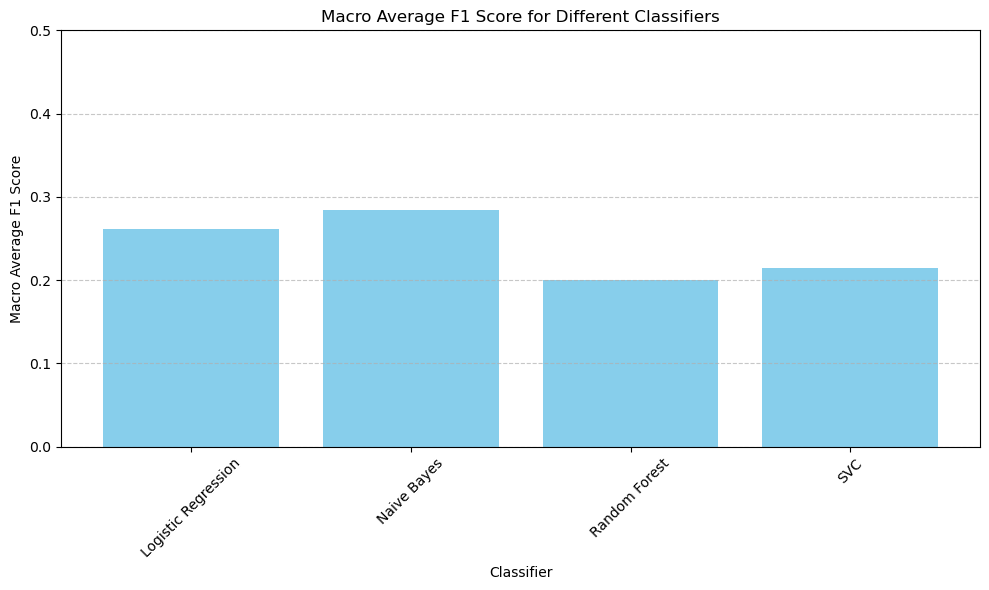

In [258]:
plot_f1_scores_for_classifiers(f1_scores_1)

# try to convert all numbers to "digit" word and see the result + delete "said" word 

In [259]:
# Convert each number to the word "digit" in top_words and delete the word "said"
top_words_with_digit_word = {word if not (word.isdigit() or word == 'said') else "digit" for word in top_words}

In [ ]:
top_words_with_digit_word

In [260]:
features_with_digit_word = create_feature_matrix(df, top_words_with_digit_word)

In [261]:
most_top_frequent_words_df_digit = pd.DataFrame(features_with_digit_word.toarray())
most_top_frequent_words_df_digit['class_label'] = df['class_label']

C:\Users\IMOE001\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Macro Average F1 score (Logistic Regression): 0.24304907264761844
Macro Average F1 score (Naive Bayes): 0.3122414210777313
Macro Average F1 score (Random Forest): 0.16893660504785066
Macro Average F1 score (SVC): 0.19870754712588104


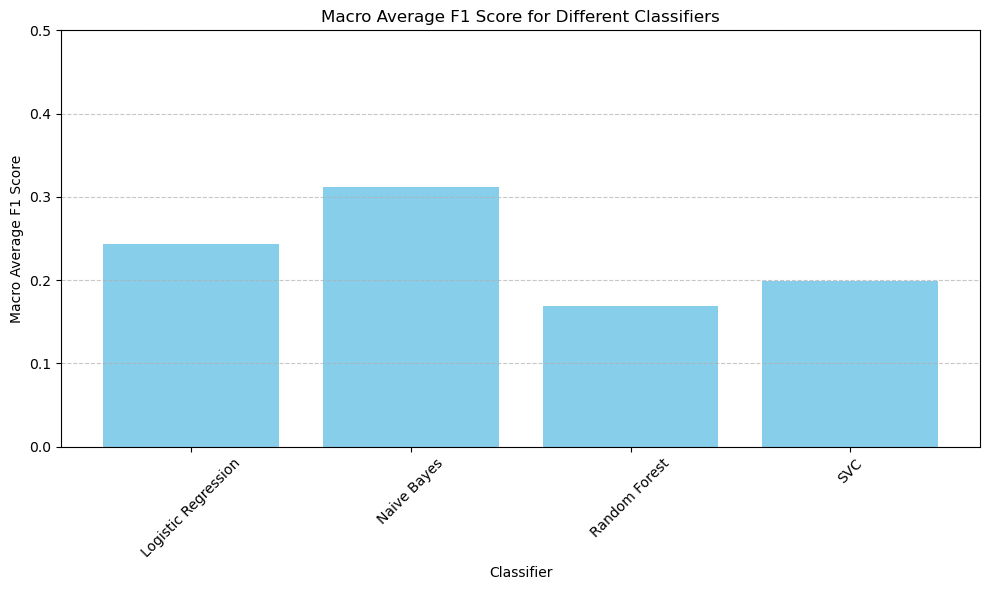

In [262]:
X_train, X_test, y_train, y_test = split_data (most_top_frequent_words_df , 'class_label' )
f1_scores_2 = evaluate_classifiers(X_train, X_test, y_train, y_test, classifiers)
plot_f1_scores_for_classifiers(f1_scores_2)

In [264]:
# #only effect on Naive Bayes

# add the length of text as a feature , and see the result 

In [265]:
df['text_len'] = df['document_content'].apply(lambda x: len(x))
df

document_content class_label  \
0      [comput, termin, system, cpml, complet, sale, ...         acq   
1      [ohio, mattress, omt, may, lower, 1st, qtr, ne...         acq   
2      [mclean, mii, us, line, set, asset, transfer, ...         acq   
3      [chemlawn, chem, rise, hope, higher, bidsautho...         acq   
4      [cofab, inc, buy, gulfex, undisclos, amount, h...         acq   
...                                                  ...         ...   
11408  [pegasu, gold, pgulf, start, mill, montana, je...        zinc   
11409  [world, zinc, stock, fall, 7700, tonn, februar...        zinc   
11410  [lme, detail, march, 1987, turnov, london, apr...        zinc   
11411  [ball, bll, suppli, penni, blank, mint, munci,...        zinc   
11412  [westmin, rais, myra, fall, capac, 33, pct, ca...        zinc   

                                    document_content_str  text_len  
0      comput termin system cpml complet sale commack...       136  
1      ohio mattress omt may lower 1st qtr net clevel...        86  
2      mclean mii us line set asset transfer cranford...        60  
3      chemlawn chem rise hope higher bidsauthor cal ...       235  
4      cofab inc buy gulfex undisclos amount houston ...        38  
...                                                  ...       ...  
11408  pegasu gold pgulf start mill montana jefferson...        74  
11409  world zinc stock fall 7700 tonn februari eindh...        93  
11410  lme detail march 1987 turnov london april 2 lo...        93  
11411  ball bll suppli penni blank mint munci ind apr...        58  
11412  westmin rais myra fall capac 33 pct calgari al...       111  

[11413 rows x 4 columns]

In [267]:
most_top_frequent_words_df_digit['text_len'] = df['text_len']

In [268]:
most_top_frequent_words_df_digit

0  1  2  3  4  5  6  7  8  9  ...  260  261  262  263  264  265  266  \
0      0  0  0  0  0  0  0  0  0  0  ...    0    0    2    0    0    0    0   
1      0  0  0  0  0  0  0  0  0  0  ...    0    0    1    2    0    0    0   
2      0  0  0  0  0  0  0  0  0  0  ...    0    0    1    0    0    0    0   
3      0  0  0  0  0  0  0  0  0  0  ...    0    0    2    1    0    1    0   
4      0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0   
...   .. .. .. .. .. .. .. .. .. ..  ...  ...  ...  ...  ...  ...  ...  ...   
11408  0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0   
11409  0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0   
11410  0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0   
11411  0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0   
11412  0  0  0  0  0  0  0  0  0  0  ...    0    0    0    1    0    0    0   

       267  class_label  text_len  
0        0          acq       136  
1        0          acq        86  
2        0          acq        60  
3        0          acq       235  
4        0          acq        38  
...    ...          ...       ...  
11408    2         zinc        74  
11409    5         zinc        93  
11410    2         zinc        93  
11411    0         zinc        58  
11412    2         zinc       111  

[11413 rows x 270 columns]

In [302]:
X_train, X_test, y_train, y_test = split_data (most_top_frequent_words_df_digit , 'class_label' )
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

C:\Users\IMOE001\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Macro Average F1 score (Logistic Regression): 0.11911438976697959
Macro Average F1 score (Naive Bayes): 0.3272179882053754
Macro Average F1 score (Random Forest): 0.23117293897097593
Macro Average F1 score (SVC): 0.01881921765125269


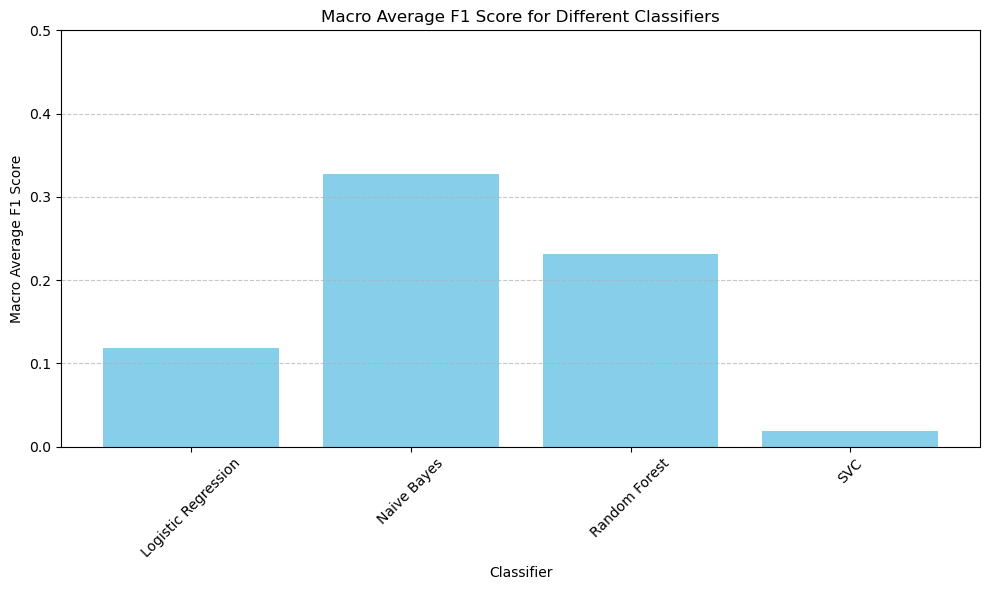

In [303]:
f1_scores_3 = evaluate_classifiers(X_train, X_test, y_train, y_test, classifiers)
plot_f1_scores_for_classifiers(f1_scores_3)

In [270]:
#get bad result :))

In [304]:
most_top_frequent_words_df_digit.drop(columns=['text_len'] , inplace = True)

In [305]:
plt.rcParams.update(plt.rcParamsDefault)

In [ ]:
# the best model untill now is Naive bayes which give me Macro F1 = 0.327

In [ ]:
# try to train it on over-sampeled data and see the result >> 

In [320]:
# address imbalance in  data using oversampling Technique 

In [127]:
def perform_oversampling(X_train, y_train):
    y_train_list = y_train.tolist()
    max_samples = max(Counter(y_train_list).values())

    sampling_strategy = {class_label: int(max_samples) for class_label in Counter(y_train_list).keys()}
    # Perform oversampling
    oversample = RandomOverSampler(sampling_strategy=sampling_strategy)
    X_over, y_over = oversample.fit_resample(X_train, y_train_list)
    return X_over, y_over

In [323]:
X_train, X_test, y_train, y_test = split_data (most_top_frequent_words_df_digit , 'class_label' )

In [324]:
x_over, y_over = perform_oversampling( X_train , y_train )

In [325]:
mnb_classifier = MultinomialNB()
mnb_classifier.fit(x_over, y_over)

MultinomialNB()

In [326]:
y_pred_test = mnb_classifier.predict(X_test)
f1_macro = f1_score(y_test, y_pred_test, average='macro')
print("Macro-average F1 score:", f1_macro)

Macro-average F1 score: 0.25810304696843067


In [328]:
# with oversampling , got the bad result .. 

# Try Ensemble learning :)

In [37]:
def train_and_evaluate_ensemble(X_train, y_train, X_test, y_test, classifiers):
    ensemble_classifier = VotingClassifier(estimators= list(classifiers.items()), voting='hard')
    ensemble_classifier.fit(X_train, y_train)

    predicted_labels = ensemble_classifier.predict(X_test)

    macro_f1 = f1_score(y_test, predicted_labels, average='macro')
    print("Macro F1 score of the ensemble classifier on the test data:", macro_f1)

In [59]:
ensemble_classifier = {
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': MultinomialNB(),
    'SVC': SVC()
}

In [340]:
X_train, X_test, y_train, y_test = split_data (most_top_frequent_words_df_digit , 'class_label' )
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

In [344]:
train_and_evaluate_ensemble(X_train, y_train, X_test, y_test, ensemble_classifier)

C:\Users\IMOE001\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Macro F1 score of the ensemble classifier on the test data: 0.28246538286082046


In [ ]:
# add Random forst to the ensambel-model 

In [343]:
train_and_evaluate_ensemble(X_train, y_train, X_test, y_test, classifiers)

C:\Users\IMOE001\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Macro F1 score of the ensemble classifier on the test data: 0.27231490429941846


In [345]:
"""
the best model for this approch the Naive Bayes model that give me 0.32 when represant each document with 
top 10 frequent words on it's class 
"""

"\nthe best model for this approch the Naive Bayes model that give me 0.32 when represant each document with \ntop 10 frequent words on it's class \n"

# 2- Represant each document with tf-idf vectore 

In [95]:
#df = preprocessed_df

In [7]:
df['document_content_str'] = df['document_content'].apply(lambda x: ' '.join(x))

In [96]:
df

document_content class_label  \
0      [comput, termin, system, cpml, complet, sale, ...         acq   
1      [ohio, mattress, omt, may, lower, 1st, qtr, ne...         acq   
2      [mclean, mii, us, line, set, asset, transfer, ...         acq   
3      [chemlawn, chem, rise, hope, higher, bidsautho...         acq   
4      [cofab, inc, buy, gulfex, undisclos, amount, h...         acq   
...                                                  ...         ...   
11408  [pegasu, gold, pgulf, start, mill, montana, je...        zinc   
11409  [world, zinc, stock, fall, 7700, tonn, februar...        zinc   
11410  [lme, detail, march, 1987, turnov, london, apr...        zinc   
11411  [ball, bll, suppli, penni, blank, mint, munci,...        zinc   
11412  [westmin, rais, myra, fall, capac, 33, pct, ca...        zinc   

                                    document_content_str  
0      comput termin system cpml complet sale commack...  
1      ohio mattress omt may lower 1st qtr net clevel...  
2      mclean mii us line set asset transfer cranford...  
3      chemlawn chem rise hope higher bidsauthor cal ...  
4      cofab inc buy gulfex undisclos amount houston ...  
...                                                  ...  
11408  pegasu gold pgulf start mill montana jefferson...  
11409  world zinc stock fall 7700 tonn februari eindh...  
11410  lme detail march 1987 turnov london april 2 lo...  
11411  ball bll suppli penni blank mint munci ind apr...  
11412  westmin rais myra fall capac 33 pct calgari al...  

[11413 rows x 3 columns]

In [97]:
tfidf = TfidfVectorizer(min_df = 5, lowercase = True, ngram_range=(1,2),  max_features= 10000,   stop_words = 'english', sublinear_tf = True)

# transform each lebel into vector
feature = tfidf.fit_transform(df['document_content_str']).toarray()

In [98]:
y = df["class_label"]

# Use Features Selection Technique

In [99]:
percentile = 10  # Percentile of top features to select
selector = SelectPercentile(score_func=chi2, percentile=percentile)
selected_features = selector.fit_transform(feature, y)  

In [100]:
len(selected_features[0])

1000

In [101]:
tf_idf = selected_features 

In [102]:
tf_idf = pd.DataFrame(tf_idf)

In [103]:
tf_idf.head(50)

0    1    2    3    4    5    6    7    8    9    ...  990  991  992  993  \
0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
1   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
2   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
4   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
5   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
6   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
7   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
8   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
9   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
10  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
11  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
12  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
13  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
14  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
15  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
16  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
17  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
18  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
19  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
20  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
21  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
22  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
23  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
24  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
25  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
26  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
27  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
28  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
29  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
30  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
31  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
32  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
33  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
34  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
35  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
36  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
37  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
38  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
39  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
40  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
41  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
42  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
43  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
44  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
45  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
46  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
47  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
48  0.0  0.0  0.0  0.0  0.0  0.0  0

# Each document represanted by tf-idf vector 

In [104]:
tf_idf['label'] = df['class_label']

In [105]:
tf_idf

0    1    2    3    4    5    6    7    8    9  ...  991  992  993  \
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
11408  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
11409  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
11410  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
11411  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
11412  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

       994  995  996  997       998  999  label  
0      0.0  0.0  0.0  0.0  0.000000  0.0    acq  
1      0.0  0.0  0.0  0.0  0.000000  0.0    acq  
2      0.0  0.0  0.0  0.0  0.000000  0.0    acq  
3      0.0  0.0  0.0  0.0  0.000000  0.0    acq  
4      0.0  0.0  0.0  0.0  0.000000  0.0    acq  
...    ...  ...  ...  ...       ...  ...    ...  
11408  0.0  0.0  0.0  0.0  0.253523  0.0   zinc  
11409  0.0  0.0  0.0  0.0  0.349200  0.0   zinc  
11410  0.0  0.0  0.0  0.0  0.202824  0.0   zinc  
11411  0.0  0.0  0.0  0.0  0.000000  0.0   zinc  
11412  0.0  0.0  0.0  0.0  0.145600  0.0   zinc  

[11413 rows x 1001 columns]

In [106]:
"""
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(tf_idf.label)

"""

'\nlabel_encoder = LabelEncoder()\nencoded_labels = label_encoder.fit_transform(tf_idf.label)\n\n'

In [111]:
X_train, X_test, y_train, y_test = split_data (tf_idf , 'label' )

C:\Users\IMOE001\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Macro Average F1 score (Logistic Regression): 0.21380675120909143
Macro Average F1 score (Naive Bayes): 0.09922783677268537
Macro Average F1 score (Random Forest): 0.2423992613476278
Macro Average F1 score (SVC): 0.27822695602525993


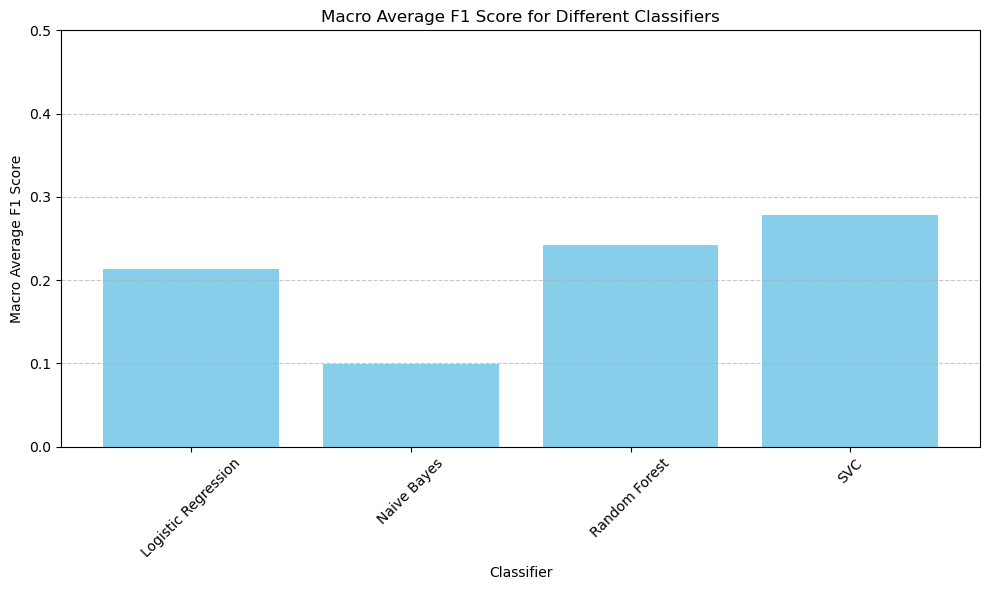

In [384]:
## use the Previous function 
f1_scores_for_tf_idf = evaluate_classifiers(X_train, X_test, y_train, y_test, classifiers)
plot_f1_scores_for_classifiers(f1_scores_for_tf_idf)

# try to use over-sampling :) 


In [130]:
x_over, y_over = perform_oversampling( X_train , y_train )

In [132]:
type(x_over)

pandas.core.frame.DataFrame

In [395]:
f1_scores_for_tf_idf_with_over_sampling = evaluate_classifiers(x_over,  X_test , y_over, y_test, classifiers)

C:\Users\IMOE001\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Macro Average F1 score (Logistic Regression): 0.34214664818443735
Macro Average F1 score (Naive Bayes): 0.28098063214217067
Macro Average F1 score (Random Forest): 0.2932686764996128
Macro Average F1 score (SVC): 0.28439642787727437


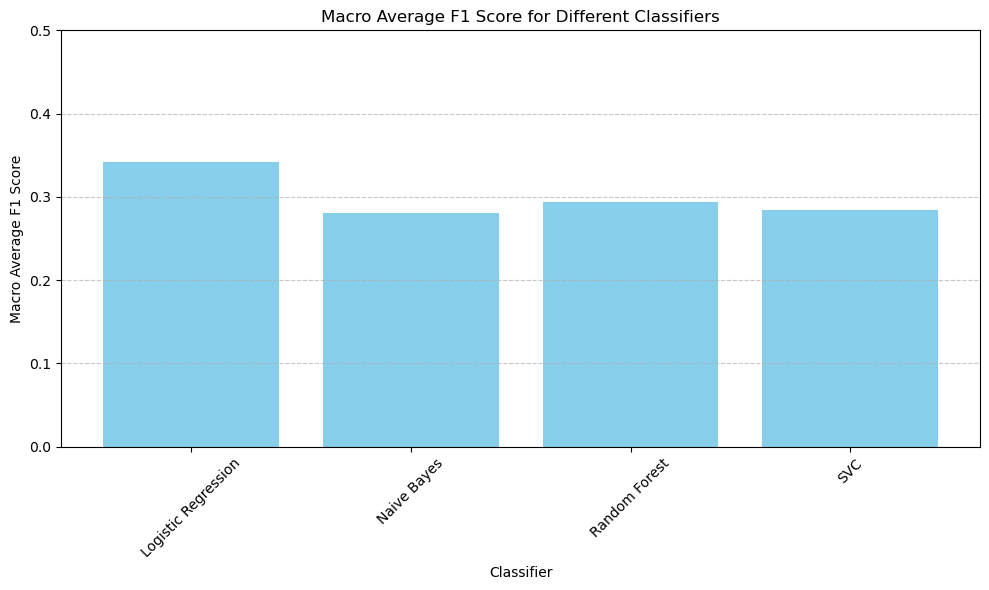

In [396]:
plot_f1_scores_for_classifiers(f1_scores_for_tf_idf_with_over_sampling)

In [ ]:
## get better result . 

In [ ]:
# got more good result 

In [397]:
# use ensemble learning with overSampling => 

In [401]:
f1_scores_for_ensambe_models_on_tf_idf_reprentation = train_and_evaluate_ensemble(x_over, y_over, X_test, y_test, classifiers)

C:\Users\IMOE001\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Macro F1 score of the ensemble classifier on the test data: 0.32573320019542196


In [515]:
## perform hyperparameter tuning for the max_features parameter in TfidfVectorizer

In [514]:
warnings.filterwarnings('ignore')

X, y = df['document_content_str'], df['class_label']

X = X.values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_over, y_train_over = perform_oversampling(X_train, y_train)

X_train_over_list = X_train_over.ravel().tolist()

pipeline = Pipeline([ #scikit-learn's Pipeline class
    ('tfidf', TfidfVectorizer()),
    ('feature_selection', SelectPercentile(score_func=chi2)),
    ('classifier', LogisticRegression(max_iter=5000))
])

param_grid = {
    'tfidf__max_features': [1000 , 5000 , 10000 ,15000 , 20000 , 25000 ] ,
    'feature_selection__percentile': [10]  
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro')

grid_search.fit(X_train_over_list, y_train_over)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'feature_selection__percentile': 10, 'tfidf__max_features': 25000}
Best Score: 0.8205215661965711


AttributeError: This 'Pipeline' has no attribute 'transform'

In [ ]:
##i have sequential order of training samples, which can lead to overfitting => so i'll use Data Shuffling 

In [112]:
tfidf = TfidfVectorizer(min_df = 5, lowercase = True, ngram_range=(1,2),  max_features= 25000,   stop_words = 'english', sublinear_tf = True)

# transform each lebel into vector
feature_25000 = tfidf.fit_transform(df['document_content_str']).toarray()

In [113]:
y = df['class_label']

In [114]:
#make feature selection 

In [115]:
percentile = 10  # Percentile of top features to select
selector = SelectPercentile(score_func=chi2, percentile=percentile)
selected_features = selector.fit_transform(feature_25000 , y)  

In [116]:
tf_idf = selected_features

In [117]:
tf_idf = pd.DataFrame(tf_idf)

In [118]:
tf_idf['label'] = df['class_label']

In [119]:
tf_idf

0    1    2    3    4    5    6    7    8    9  ...  2491  2492  \
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   
11408  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
11409  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
11410  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
11411  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
11412  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   

           2493  2494      2495      2496      2497  2498  2499  label  
0      0.000000   0.0  0.000000  0.000000  0.000000   0.0   0.0    acq  
1      0.000000   0.0  0.000000  0.000000  0.000000   0.0   0.0    acq  
2      0.000000   0.0  0.000000  0.000000  0.000000   0.0   0.0    acq  
3      0.000000   0.0  0.000000  0.000000  0.000000   0.0   0.0    acq  
4      0.000000   0.0  0.000000  0.000000  0.000000   0.0   0.0    acq  
...         ...   ...       ...       ...       ...   ...   ...    ...  
11408  0.187599   0.0  0.000000  0.000000  0.000000   0.0   0.0   zinc  
11409  0.296784   0.0  0.000000  0.000000  0.264705   0.0   0.0   zinc  
11410  0.154977   0.0  0.000000  0.213031  0.000000   0.0   0.0   zinc  
11411  0.000000   0.0  0.000000  0.000000  0.000000   0.0   0.0   zinc  
11412  0.119989   0.0  0.167964  0.000000  0.000000   0.0   0.0   zinc  

[11413 rows x 2501 columns]

In [120]:
classifiers_with_edit = {
    'Logistic Regression': LogisticRegression(max_iter=5000),
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(),
    'SVC': SVC()
}

In [122]:
tf_idf

0    1    2    3    4    5    6    7    8    9  ...  2491  2492  \
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   
11408  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
11409  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
11410  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
11411  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
11412  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   

           2493  2494      2495      2496      2497  2498  2499  label  
0      0.000000   0.0  0.000000  0.000000  0.000000   0.0   0.0    acq  
1      0.000000   0.0  0.000000  0.000000  0.000000   0.0   0.0    acq  
2      0.000000   0.0  0.000000  0.000000  0.000000   0.0   0.0    acq  
3      0.000000   0.0  0.000000  0.000000  0.000000   0.0   0.0    acq  
4      0.000000   0.0  0.000000  0.000000  0.000000   0.0   0.0    acq  
...         ...   ...       ...       ...       ...   ...   ...    ...  
11408  0.187599   0.0  0.000000  0.000000  0.000000   0.0   0.0   zinc  
11409  0.296784   0.0  0.000000  0.000000  0.264705   0.0   0.0   zinc  
11410  0.154977   0.0  0.000000  0.213031  0.000000   0.0   0.0   zinc  
11411  0.000000   0.0  0.000000  0.000000  0.000000   0.0   0.0   zinc  
11412  0.119989   0.0  0.167964  0.000000  0.000000   0.0   0.0   zinc  

[11413 rows x 2501 columns]

In [66]:
X_train, X_test, y_train, y_test = split_data (tf_idf , 'label' )
x_over, y_over = perform_oversampling( X_train , y_train )

Macro Average F1 score (Logistic Regression): 0.37917843414331437
Macro Average F1 score (Naive Bayes): 0.33617201696339644
Macro Average F1 score (Random Forest): 0.31214952941899304
Macro Average F1 score (SVC): 0.3249780138373926


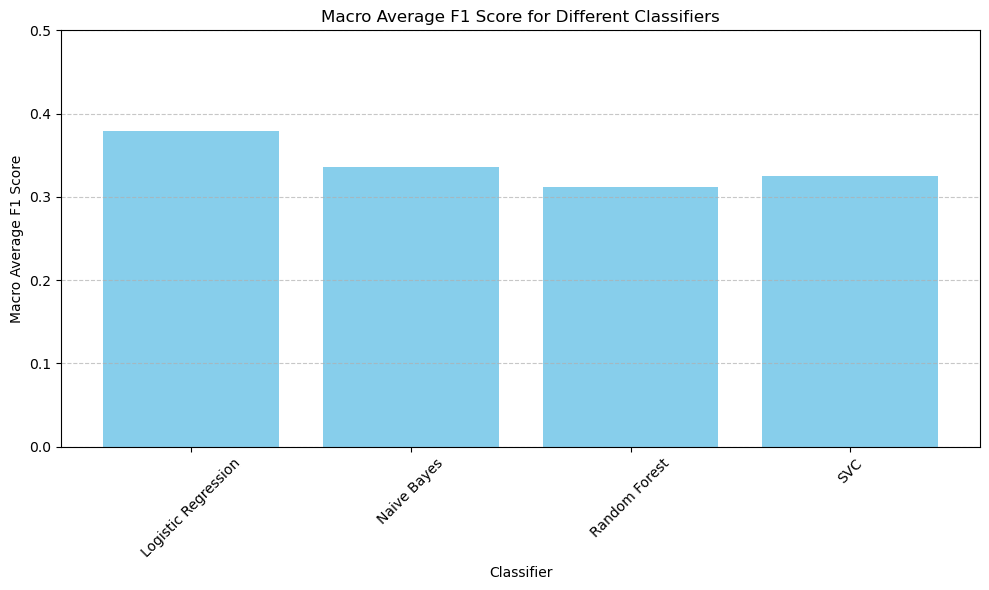

In [528]:
f1_scores_for_tf_idf = evaluate_classifiers( x_over , X_test , y_over , y_test , classifiers_with_edit )
plot_f1_scores_for_classifiers(f1_scores_for_tf_idf)

In [ ]:
# try to train on ensambel .. done 

In [67]:
f1_scores_for_ensambe_models_on_tf_idf_reprentation_25000 = train_and_evaluate_ensemble(x_over, y_over, X_test, y_test, classifiers_with_edit)

Macro F1 score of the ensemble classifier on the test data: 0.34261679418963814


In [ ]:
# better than last one . 

In [ ]:
# the better model until now is the logistic regression with tf-idf represntation with 25000 features and oversampling . 

In [ ]:
#try to make shuffling for Data .. 

In [68]:
shuffled_tfidf = tf_idf.sample(frac=1 , random_state=42)  # frac=1 means to sample the entire DataFrame

In [69]:
shuffled_tfidf

0    1    2    3    4    5    6    7    8    9  ...  2491  2492  \
5908   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
8949   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
5665   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
3538   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
6248   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   
11284  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
5191   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
5390   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
860    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
7270   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   

       2493  2494  2495  2496  2497  2498  2499     label  
5908    0.0   0.0   0.0   0.0   0.0   0.0   0.0       gnp  
8949    0.0   0.0   0.0   0.0   0.0   0.0   0.0     trade  
5665    0.0   0.0   0.0   0.0   0.0   0.0   0.0      earn  
3538    0.0   0.0   0.0   0.0   0.0   0.0   0.0      earn  
6248    0.0   0.0   0.0   0.0   0.0   0.0   0.0     grain  
...     ...   ...   ...   ...   ...   ...   ...       ...  
11284   0.0   0.0   0.0   0.0   0.0   0.0   0.0     wheat  
5191    0.0   0.0   0.0   0.0   0.0   0.0   0.0      earn  
5390    0.0   0.0   0.0   0.0   0.0   0.0   0.0      earn  
860     0.0   0.0   0.0   0.0   0.0   0.0   0.0       acq  
7270    0.0   0.0   0.0   0.0   0.0   0.0   0.0  money-fx  

[11413 rows x 2501 columns]

In [110]:
X_train, X_test, y_train, y_test = split_data (shuffled_tfidf , 'label' )
x_over, y_over = perform_oversampling( X_train , y_train )

In [115]:
type(y_test)

pandas.core.series.Series

Macro Average F1 score (Logistic Regression): 0.32799616786502994
Macro Average F1 score (Naive Bayes): 0.2990224318558687
Macro Average F1 score (Random Forest): 0.29509101965208356
Macro Average F1 score (SVC): 0.28341815951973004


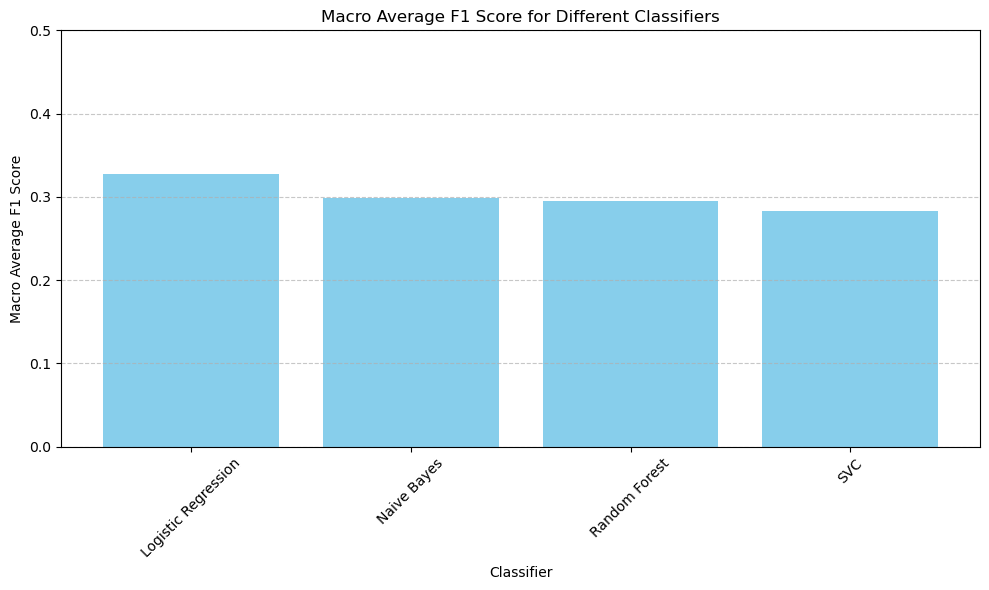

In [71]:
f1_scores_for_shuffled_tfidf = evaluate_classifiers( x_over , X_test , y_over , y_test , classifiers_with_edit )
plot_f1_scores_for_classifiers(f1_scores_for_shuffled_tfidf)

# 3- Represent Documents as Embeddings

In [ ]:
# represntation + training on each classifer + over sampling and retrain + use ensambel + shuffling .. 

In [76]:
word2vec_model_path = 'C:\\Users\\IMOE001\\Desktop\\GoogleNews-vectors-negative300.bin'
fasttext_model_path = 'C:\\Users\\IMOE001\\Desktop\\wiki-news-300d-1M.vec'

In [77]:
glove_model = gensim.downloader.load('glove-wiki-gigaword-300')
word2vec_model = KeyedVectors.load_word2vec_format(word2vec_model_path, binary=True)
fasttext_model = KeyedVectors.load_word2vec_format(fasttext_model_path)

In [89]:
def word_embedding(document, model):
    word_embeddings = []
    for word in document:
        if word in model:
            word_embeddings.append(model[word])
    if word_embeddings:
        return np.mean(word_embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)  # Return zero vector if no words are found


In [90]:
df_word2vec_rep = pd.DataFrame(columns=['embedding'])
df_word2vec_rep['embedding'] = df['document_content'].apply(lambda x: word_embedding(x, word2vec_model))

In [92]:
len(df_word2vec_rep['embedding'][0])

300

In [93]:
df_word2vec_rep['label'] = df['class_label']

In [118]:
X_train, X_test, y_train, y_test = split_data (df_word2vec_rep , 'label' )

In [119]:
x_over, y_over = perform_oversampling( X_train , y_train )

In [144]:
type(y_over)

list

In [145]:
y_over = pd.Series(y_over)

Macro Average F1 score (Logistic Regression): 0.3209911229784952
Macro Average F1 score (Naive Bayes): 0.28838372541373514
Macro Average F1 score (Random Forest): 0.26895117083212094
Macro Average F1 score (SVC): 0.27182052671515294


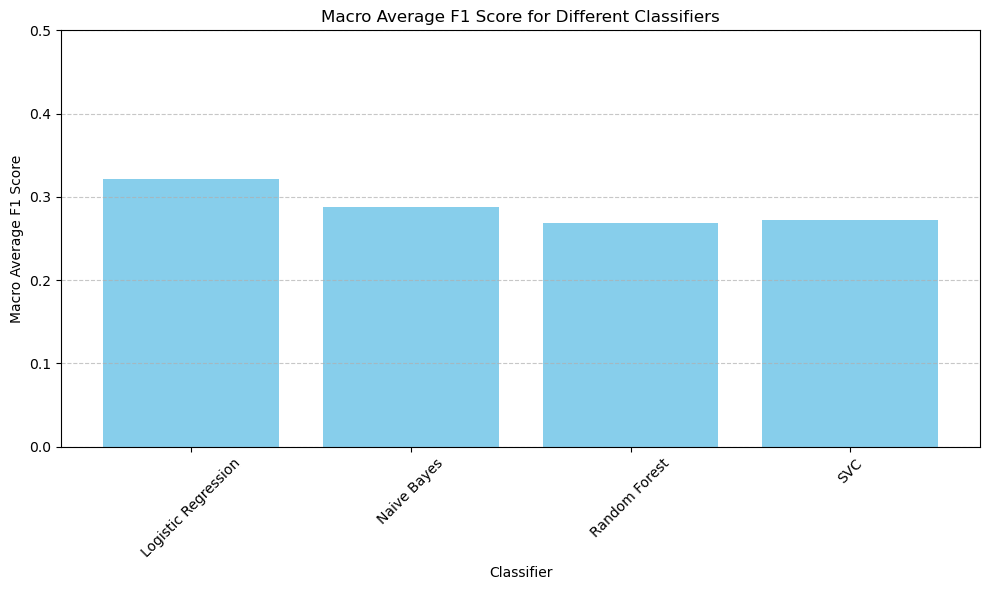

In [146]:
f1_scores_for_word_2_vec = evaluate_classifiers( x_over , X_test , y_over , y_test , classifiers_with_edit )
plot_f1_scores_for_classifiers(f1_scores_for_word_2_vec)

In [ ]:
## use fasttext model 

In [276]:
df_fasttext_rep = pd.DataFrame(columns=['embedding'])
df_fasttext_rep['embedding'] = df['document_content'].apply(lambda x: word_embedding(x, fasttext_model))

In [277]:
len(df_fasttext_rep['embedding'][0])

300

In [278]:
df_fasttext_rep['label'] = df['class_label']

In [ ]:
df_features = pd.DataFrame(df_fasttext_rep['embedding'].tolist())
df_combined = pd.concat([df_fasttext_rep, df_features], axis=1)

In [305]:
df_combined

embedding label         0  \
0      [-0.016292231157422066, -0.032486408948898315,...   acq -0.016292   
1      [0.015184124931693077, -0.020322224125266075, ...   acq  0.015184   
2      [-0.0007232558564282954, 0.04364418610930443, ...   acq -0.000723   
3      [-0.015045284293591976, -0.030025800690054893,...   acq -0.015045   
4      [-0.0001818195596570149, 0.0036727292463183403...   acq -0.000182   
...                                                  ...   ...       ...   
11408  [-0.010417546145617962, -0.006561406422406435,...  zinc -0.010418   
11409  [-0.043447282165288925, -0.0031490910332649946...  zinc -0.043447   
11410  [-0.08236182481050491, -0.022083638235926628, ...  zinc -0.082362   
11411  [-0.007587804924696684, 0.0002024406276177615,...  zinc -0.007588   
11412  [-0.03261817619204521, -0.025457143783569336, ...  zinc -0.032618   

              1         2         3         4         5         6         7  \
0     -0.032486 -0.021978 -0.029223 -0.014201  0.014585  0.003459 -0.014156   
1     -0.020322 -0.031783 -0.025557 -0.002617  0.012837 -0.003181 -0.020551   
2      0.043644 -0.017400 -0.000551  0.018658 -0.018105 -0.005153 -0.008002   
3     -0.030026 -0.026035 -0.023884 -0.000919 -0.005742  0.017709 -0.014977   
4      0.003673  0.026168 -0.006045 -0.001400 -0.000327  0.038886 -0.019950   
...         ...       ...       ...       ...       ...       ...       ...   
11408 -0.006561  0.001998 -0.032937 -0.013644 -0.021712  0.011274 -0.000896   
11409 -0.003149 -0.025722 -0.021367  0.002076  0.087718  0.024820 -0.017476   
11410 -0.022084  0.023209  0.012240 -0.014535  0.027507  0.012569 -0.003860   
11411  0.000202 -0.101817 -0.041759  0.030529 -0.011363  0.063934 -0.020537   
11412 -0.025457 -0.035903 -0.012649  0.019258  0.027730 -0.001757 -0.016388   

       ...       290       291       292       293       294       295  \
0      ... -0.040856 -0.024429 -0.010952  0.035398 -0.013874  0.026902   
1      ... -0.030678  0.012127 -0.003510  0.029706  0.051054  0.002810   
2      ... -0.021037 -0.010121 -0.026142  0.035912 -0.000198  0.047579   
3      ... -0.023101 -0.008540  0.005959  0.026056  0.028765  0.033183   
4      ... -0.036905 -0.035227 -0.014905  0.047564 -0.046032  0.063364   
...    ...       ...       ...       ...       ...       ...       ...   
11408  ... -0.010070  0.009179 -0.036447  0.025630  0.042412  0.006126   
11409  ... -0.015915  0.039618 -0.024105  0.038993 -0.005209 -0.006802   
11410  ... -0.026658  0.015842 -0.050816  0.028231 -0.028364  0.042969   
11411  ...  0.013837  0.000398  0.001554  0.029680  0.007646  0.005678   
11412  ... -0.019039  0.018116 -0.013781  0.028409  0.032900  0.029294   

            296       297       298       299  
0     -0.007980  0.100656  0.018171 -0.000081  
1     -0.002765  0.086368  0.029865 -0.006162  
2      0.006949  0.094358 -0.012409 -0.028451  
3     -0.014767  0.115431  0.026381  0.004811  
4     -0.001114  0.044700  0.041500  0.001300  
...         ...       ...       ...       ...  
11408 -0.019977  0.054607  0.038596  0.017791  
11409 -0.010545 -0.014304  0.022958  0.024269  
11410 -0.009102  0.070820  0.089595 -0.004449  
11411 -0.001737  0.019290  0.042490 -0.044488  
11412 -0.014829  0.044957  0.027182  0.034166  

[11413 rows x 302 columns]

In [319]:
X = df_combined.drop(columns=['embedding' , 'label'])  

In [320]:
y = df_combined['label']

In [321]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [322]:
x_over, y_over = perform_oversampling( X_train , y_train )

In [328]:
LogisticRegression = {
    'Logistic Regression': LogisticRegression()
}

In [330]:
f1_scores_for_fasttext = evaluate_classifiers( x_over , X_test , y_over , y_test , LogisticRegression )

Macro Average F1 score (Logistic Regression): 0.287863653013611


C:\Users\IMOE001\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
## use Glove model 

In [331]:
df_Glove_rep = pd.DataFrame(columns=['embedding'])
df_Glove_rep['embedding'] = df['document_content'].apply(lambda x: word_embedding(x, glove_model))

In [332]:
df_Glove_rep['label'] = df['class_label']

In [333]:
df_features_2 = pd.DataFrame(df_Glove_rep['embedding'].tolist())
df_combined_2 = pd.concat([df_Glove_rep, df_features_2], axis=1)

In [334]:
df_combined_2

embedding label         0  \
0      [-0.12374827, 0.056758214, -0.070338346, 0.059...   acq -0.123748   
1      [-0.08102715, 0.0864118, -0.06962546, 0.027563...   acq -0.081027   
2      [0.015427381, -0.016511932, 0.021372445, 0.087...   acq  0.015427   
3      [-0.10732772, -0.009258359, -0.07200178, 0.061...   acq -0.107328   
4      [0.19392782, 0.0057042106, 0.065982044, 0.0367...   acq  0.193928   
...                                                  ...   ...       ...   
11408  [-0.16761784, 0.086230844, -0.16556935, 0.0789...  zinc -0.167618   
11409  [0.031608917, 0.07207694, 0.0055022333, 0.0239...  zinc  0.031609   
11410  [-0.26296094, 0.12923689, -0.103013635, 0.0312...  zinc -0.262961   
11411  [0.023383252, 0.04081782, -0.18195216, 0.15318...  zinc  0.023383   
11412  [-0.1271976, 0.08130559, -0.067817494, -0.0005...  zinc -0.127198   

              1         2         3         4         5         6         7  \
0      0.056758 -0.070338  0.059848 -0.027312 -0.065880  0.051545  0.088411   
1      0.086412 -0.069625  0.027564 -0.122148 -0.030653  0.013682 -0.001346   
2     -0.016512  0.021372  0.087786 -0.002259 -0.116522 -0.051725 -0.049023   
3     -0.009258 -0.072002  0.061287  0.003764 -0.032773  0.087064  0.062210   
4      0.005704  0.065982  0.036707  0.003075 -0.129449  0.059254  0.064757   
...         ...       ...       ...       ...       ...       ...       ...   
11408  0.086231 -0.165569  0.078975 -0.011665 -0.097047 -0.009846 -0.053759   
11409  0.072077  0.005502  0.023951  0.181032  0.067546 -0.117271 -0.053546   
11410  0.129237 -0.103014  0.031299 -0.036815  0.080408  0.081669 -0.056844   
11411  0.040818 -0.181952  0.153185  0.020913 -0.060390 -0.024208 -0.048925   
11412  0.081306 -0.067817 -0.000516  0.013197 -0.002115  0.044917  0.027013   

       ...       290       291       292       293       294       295  \
0      ... -0.120239 -0.105293  0.031676 -0.068437  0.148771  0.219762   
1      ... -0.046674 -0.148005 -0.034711  0.014126  0.170490  0.356099   
2      ...  0.032440 -0.022857  0.040997  0.056734  0.102244  0.253698   
3      ... -0.049695 -0.099876  0.033627  0.072427  0.175532  0.200871   
4      ... -0.022534  0.054049 -0.033887  0.128355  0.067041  0.273958   
...    ...       ...       ...       ...       ...       ...       ...   
11408  ... -0.130157  0.032024 -0.090754  0.049692  0.087032  0.289459   
11409  ...  0.002346  0.011434 -0.072255 -0.064838  0.179300  0.296359   
11410  ... -0.252913  0.058656 -0.261375  0.180372  0.218216  0.348855   
11411  ...  0.007288 -0.009319 -0.022880  0.133526  0.122387  0.272977   
11412  ... -0.200467  0.074984  0.049545  0.039254  0.237395  0.352807   

            296       297       298       299  
0     -0.045503 -0.142887  0.090530 -0.036473  
1     -0.128817 -0.222102 -0.038295  0.038555  
2      0.059791 -0.149523 -0.186957  0.032875  
3     -0.053468 -0.193625 -0.036466  0.029596  
4      0.007549 -0.058678 -0.098438  0.054314  
...         ...       ...       ...       ...  
11408 -0.034131 -0.166492  0.019578  0.099386  
11409 -0.023236 -0.292129  0.120986 -0.047072  
11410  0.090514 -0.377352  0.090558 -0.026060  
11411  0.030597 -0.160347  0.023704 -0.032299  
11412 -0.080933 -0.267176  0.032231  0.032348  

[11413 rows x 302 columns]

In [335]:
X = df_combined_2.drop(columns=['embedding' , 'label'])  

In [336]:
y = df_combined_2['label']

In [337]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [338]:
x_over, y_over = perform_oversampling( X_train , y_train )

In [339]:
f1_scores_for_Glove = evaluate_classifiers( x_over , X_test , y_over , y_test , LogisticRegression )

Macro Average F1 score (Logistic Regression): 0.27073459603598277


C:\Users\IMOE001\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
## plot the result 

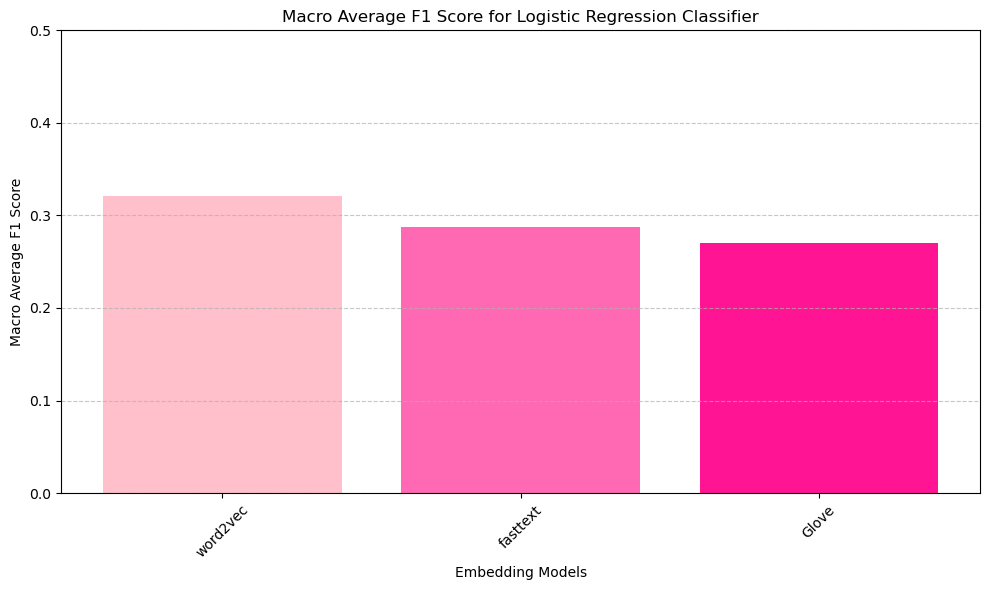

In [342]:
plt.figure(figsize=(10, 6))
plt.bar(['word2vec', 'fasttext', 'Glove'], [f1_scores_for_word_2_vec['Logistic Regression'], f1_scores_for_fasttext['Logistic Regression'], f1_scores_for_Glove['Logistic Regression']], color=['#FFC0CB', '#FF69B4', '#FF1493'])
plt.xlabel('Embedding Models')
plt.ylabel('Macro Average F1 Score')
plt.title('Macro Average F1 Score for Logistic Regression Classifier')
plt.ylim(0, 0.5)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [347]:
## summrize all the result  

In [348]:
## try to make  tunning for parmetrs of logistic Regression 

In [54]:
X_train, X_test, y_train, y_test = split_data (tf_idf , 'label' )
x_over, y_over = perform_oversampling( X_train , y_train )

In [68]:
logistic_regression = LogisticRegression()

param_grid = {
     # Algorithm to use in optimization problem
    'max_iter': [5000 ,10000 , 15000]  # Maximum number of iterations
}

scorer = make_scorer(f1_score, average='macro')

grid_search = GridSearchCV(estimator=logistic_regression, param_grid=param_grid, scoring=scorer, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(x_over, y_over)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_model = grid_search.best_estimator_

f1_score_train = f1_score(y_over, best_model.predict(y_over), average='macro')
f1_score_test = f1_score(y_test, best_model.predict(X_test), average='macro')
print("F1 Score on Train Set:", f1_score_train)
print("F1 Score on Test Set:", f1_score_test)


Fitting 5 folds for each of 3 candidates, totalling 15 fits


C:\Users\IMOE001\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


MemoryError: Unable to allocate 3.89 GiB for an array with shape (2500, 208800) and data type float64

In [66]:
LogisticRegression = {
    'Logistic Regression': LogisticRegression(max_iter = 7000 , C=1.0 , solver='liblinear', random_state=42 )
}

In [67]:
f1_scores_for_tf_idf = evaluate_classifiers( x_over , X_test , y_over , y_test , LogisticRegression  )

Macro Average F1 score (Logistic Regression): 0.3825720398452276


In [224]:
X_train, X_test, y_train, y_test = split_data (tf_idf , 'label' )
x_over, y_over = perform_oversampling( X_train , y_train )

In [196]:
LogisticRegression = LogisticRegression(max_iter=7000, C=1.0, solver='liblinear', random_state=42)

cv_scores = cross_val_score(LogisticRegression, x_over, y_over, cv=5, scoring='f1_macro')

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Cross-Validation Scores: [0.81915075 0.82168921 0.81761962 0.82025055 0.82120005]
Mean CV Score: 0.8199820360375801


In [244]:
X = tf_idf.drop(columns=['label'])
y = tf_idf['label']

In [200]:
LogisticRegression.fit(x_over, y_over)
y_pred_test = LogisticRegression.predict(X)
test_score = f1_score(y, y_pred_test, average='macro')
print("F1 Score on Test Data:", test_score)

F1 Score on Test Data: 0.5700235428102923


In [ ]:
## Model Serialization 

In [245]:
model_pkl_file = "LogisticRegression.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(LogisticRegression, file)

In [246]:
with open(model_pkl_file, 'rb') as file:  
    model = pickle.load(file)

In [247]:
## try to make prediction again 

In [248]:
y_pred = model.predict(X)
test_score = f1_score(y, y_pred, average='macro')
print("F1 Score on Test Data:", test_score)
precision_macro_avg = precision_score(y, y_pred, average='macro')
print("Precision Macro Average:", precision_macro_avg)
recall_macro_avg = recall_score(y, y_pred, average='macro')
print("Recall Macro Average:", recall_macro_avg)

F1 Score on Test Data: 0.5569385641026713
Precision Macro Average: 0.5089702536005246
Recall Macro Average: 0.7274589129191638


C:\Users\IMOE001\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [249]:
print(classification_report(y, y_pred)) 

                 precision    recall  f1-score   support

            acq       0.79      0.90      0.84      1650
           alum       0.91      0.91      0.91        35
         barley       0.32      0.65      0.43        37
            bop       0.47      0.76      0.58        75
        carcass       0.49      0.68      0.57        50
     castor-oil       0.00      0.00      0.00         1
          cocoa       0.88      0.91      0.89        55
        coconut       0.50      1.00      0.67         4
    coconut-oil       0.40      0.50      0.44         4
         coffee       0.86      0.89      0.88       111
         copper       0.82      0.79      0.80        47
     copra-cake       0.12      1.00      0.21         2
           corn       0.43      0.48      0.45       181
         cotton       0.38      0.62      0.47        39
     cotton-oil       0.33      1.00      0.50         1
            cpi       0.88      0.81      0.84        69
            cpu       1.00    

C:\Users\IMOE001\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\IMOE001\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\IMOE001\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


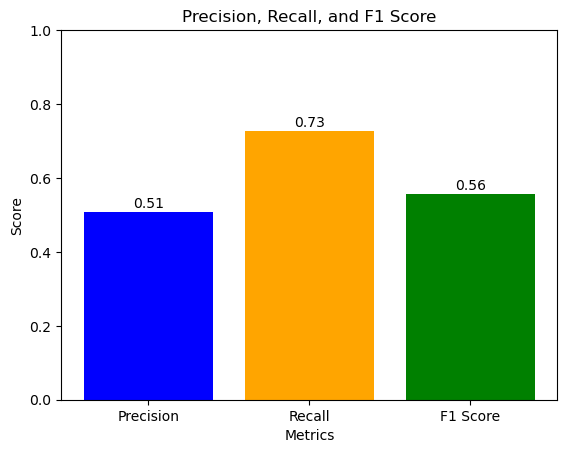

In [250]:
labels = ['Precision', 'Recall', 'F1 Score']
values = [precision_macro_avg, recall_macro_avg, test_score]

plt.bar(labels, values, color=['blue', 'orange', 'green'])
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score')
plt.ylim(0, 1)  # Set y-axis limit to [0, 1] for better visualization

# Add the scores as text on top of the bars
for i, value in enumerate(values):
    plt.text(i, value + 0.01, f'{value:.2f}', ha='center')

plt.show()

In [262]:
expirements = [42 , 43 , 47]

In [264]:
warnings.filterwarnings('ignore')
expirement_number = 0 ;
for sample in expirements:
    expirement_number = expirement_number + 1
    print(" Expirement : " , expirement_number )
    random_samples = tf_idf.sample(n=4000, random_state= sample)
    X_for_random = random_samples.drop(columns=['label'])
    y_for_random = random_samples['label']
    y_pred_rand = model.predict(X_for_random)
    test_score = f1_score(y_for_random, y_pred_rand, average='macro')
    print("F1 Score on Test Data:", test_score)
    precision_macro_avg = precision_score(y_for_random, y_pred_rand, average='macro')
    print("Precision Macro Average:", precision_macro_avg)
    recall_macro_avg = recall_score(y_for_random, y_pred_rand, average='macro')
    print("Recall Macro Average:", recall_macro_avg)

 Expirement :  1
F1 Score on Test Data: 0.5760766285636454
Precision Macro Average: 0.5390466723142265
Recall Macro Average: 0.7146761411889648
 Expirement :  2
F1 Score on Test Data: 0.55106852536015
Precision Macro Average: 0.5234849529996185
Recall Macro Average: 0.6664604425473707
 Expirement :  3
F1 Score on Test Data: 0.5678022217210544
Precision Macro Average: 0.5341357749927967
Recall Macro Average: 0.7081126143884136
